# Deep Learning


## Import de librerías necesarias  

Descomentar las siguientes líneas en caso de necesitar instalar alguno de los siguientes requisitos en el entorno de ejecución:

In [ ]:
#!pip install pandas
#!pip install matplotlib
#!pip install numpy
#!pip install scikit-learn
#!pip install seaborn
!pip install optuna
#!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.3 MB/s eta 0:00:00


In [ ]:
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Import de librerías y módulos necesarios:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
import optuna
import random

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, mean_absolute_error



## Análisis exploratorio y limpieza de datos

### Conjunto de datos  

Obtengo el conjunto de datos desde la ubicación en google drive para lectura en formato CSV:

In [ ]:
# URL de descarga del archivo
url = 'https://drive.google.com/uc?id=1X8_G5BpQMi-Nnbtms2RL8lcWSxzD8ixd'

# Leer los datos en un DataFrame
df = pd.read_csv(url)

### Estructura y tipos de dato

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


Se observa que el dataset tiene 550068 filas.  
Las features en general no tienen datos nulos, excepto   'Product_Category_2' y 'Product_Category_3'.  

In [ ]:
# Guardar el dataset original como línea base antes de iniciar la limpieza de datos
df0 = df.copy()

# Visualizar ejemplos de datos
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


La columna <u>target</u> sería <b>"Purchase"</b> que representa el monto de compra.

<u>Features numéricas:</u>  

In [ ]:
for i in df.select_dtypes(include=['int64', 'float64']).columns:
  if i != 'Purchase':
    print(i)

User_ID
Occupation
Marital_Status
Product_Category_1
Product_Category_2
Product_Category_3


<u>Features categóricas:<u>  

In [ ]:
for i in df.select_dtypes(include=['object']).columns:
    print(i)

Product_ID
Gender
Age
City_Category
Stay_In_Current_City_Years


### Chequeo de duplicados

In [ ]:
# Comprobar si hay datos duplicados
duplicates = df.duplicated()

print(f"Número de filas duplicadas: {duplicates.sum()}")

Número de filas duplicadas: 0


### Chequeo de consistencia  

In [ ]:
# Verificar que no hay columnas no nulas representando valores nulos
df.astype('str').eq('-').any(axis=0)

,0
User_ID,False
Product_ID,False
Gender,False
Age,False
Occupation,False
City_Category,False
Stay_In_Current_City_Years,False
Marital_Status,False
Product_Category_1,False
Product_Category_2,False


In [ ]:
# Verificar que no hay columnas no nulas en blanco
df.astype('str').eq('').any(axis=0)

,0
User_ID,False
Product_ID,False
Gender,False
Age,False
Occupation,False
City_Category,False
Stay_In_Current_City_Years,False
Marital_Status,False
Product_Category_1,False
Product_Category_2,False


Verificada la limpieza del dataset, continúo con la observación de los valores posibles para cada columna:  

In [ ]:
for c in df.columns:
  print(f"\n* Valores posibles de la columna '{c} ({df[c].dtype})':")
  print(df[c].unique())
  if pd.api.types.is_numeric_dtype(df[c]):
    # Columna numérica
    print(f"Rango numérico: {df[c].min()} - {df[c].max()}")


* Valores posibles de la columna 'User_ID (int64)':
[1000001 1000002 1000003 ... 1004113 1005391 1001529]
Rango numérico: 1000001 - 1006040

* Valores posibles de la columna 'Product_ID (object)':
['P00069042' 'P00248942' 'P00087842' ... 'P00370293' 'P00371644'
 'P00370853']

* Valores posibles de la columna 'Gender (object)':
['F' 'M']

* Valores posibles de la columna 'Age (object)':
['0-17' '55+' '26-35' '46-50' '51-55' '36-45' '18-25']

* Valores posibles de la columna 'Occupation (int64)':
[10 16 15  7 20  9  1 12 17  0  3  4 11  8 19  2 18  5 14 13  6]
Rango numérico: 0 - 20

* Valores posibles de la columna 'City_Category (object)':
['A' 'C' 'B']

* Valores posibles de la columna 'Stay_In_Current_City_Years (object)':
['2' '4+' '3' '1' '0']

* Valores posibles de la columna 'Marital_Status (int64)':
[0 1]
Rango numérico: 0 - 1

* Valores posibles de la columna 'Product_Category_1 (int64)':
[ 3  1 12  8  5  4  2  6 14 11 13 15  7 16 18 10 17  9 20 19]
Rango numérico: 1 - 20

* V

Para la columna '**Gender**', aplico la siguiente codificación:  
'M' = 1  
'F' = 0  



In [ ]:
# Agregar la columna Gender codificada
df['Gender_encoded'] = (df['Gender'].map({'M': 1, 'F': 0})).astype(int)

df[['Gender', 'Gender_encoded']].value_counts()

,,count
Gender,Gender_encoded,
M,1,414259
F,0,135809


La columna '**Age**' representa rangos etarios consecutivos, y esto sugiere un orden.  
La columna '**Stay_In_Current_City_Years**' también es ordinal, por lo que, les aplico la siguiente codificación:   

In [ ]:
age_mapping = {
    '0-17': 0,
    '18-25': 1,
    '26-35': 2,
    '36-45': 3,
    '46-50': 4,
    '51-55': 5,
    '55+': 6
}

# Agregar la columna codificada
df['Age_encoded'] = (df['Age'].map(age_mapping)).astype(int)
df[['Age', 'Age_encoded']].value_counts()

,,count
Age,Age_encoded,
26-35,2,219587
36-45,3,110013
18-25,1,99660
46-50,4,45701
51-55,5,38501
55+,6,21504
0-17,0,15102


In [ ]:
stay_mapping = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4+': 4
}

# Agregar la columna codificada
df['Stay_In_Current_City_Years_encoded'] = (df['Stay_In_Current_City_Years'].map(stay_mapping)).astype(int)
df[['Stay_In_Current_City_Years', 'Stay_In_Current_City_Years_encoded']].value_counts()

,,count
Stay_In_Current_City_Years,Stay_In_Current_City_Years_encoded,
1,1,193821
2,2,101838
3,3,95285
4+,4,84726
0,0,74398


Para las columnas '**Occupation**' y '**City_Category**' no hay relación de orden entre un valor y otro, por lo que, aplico *One Hot Encoding*:  

In [ ]:
# OHE para Occupation
occupation_dummies = pd.get_dummies(df['Occupation'], prefix='Occupation', drop_first=True)

# Concatenar el DataFrame original con las nuevas columnas
df = pd.concat([df, occupation_dummies], axis=1)

df.filter(like='Occupation').head()

,Occupation,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,Occupation_8,Occupation_9,...,Occupation_11,Occupation_12,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20
0,10,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,10,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,10,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,10,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,16,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [ ]:
# OHE para City
city_dummies = pd.get_dummies(df['City_Category'], prefix='City', drop_first=True)

# Concatenar el DataFrame original con las nuevas columnas
df = pd.concat([df, city_dummies], axis=1)

df.filter(regex='^City').head()

,City_Category,City_B,City_C
0,A,False,False
1,A,False,False
2,A,False,False
3,A,False,False
4,C,False,True


Las columnas '**Product_Category_n**' representan categorización en tres niveles de un mismo producto.  
Para verificar esto, agrupo por 'Product_ID':  

In [ ]:
# Agrupar por ID de Producto valores únicos de categorías
products = df.groupby("Product_ID")[['Product_Category_1', 'Product_Category_2', 'Product_Category_3']].agg(lambda x: list(x.unique())).reset_index()

# Convertir listas en tuplas para verificar duplicados
products['Product_Category_1'] = products['Product_Category_1'].apply(tuple)
products['Product_Category_2'] = products['Product_Category_2'].apply(tuple)
products['Product_Category_3'] = products['Product_Category_3'].apply(tuple)

# Verificar duplicados en el resultado
duplicates = products[products.duplicated()]

if duplicates.empty:
    print("No hay filas duplicadas en el resultado.")
else:
    print("Hay filas duplicadas en el resultado:")
    print(duplicates)

products.head()

No hay filas duplicadas en el resultado.


,Product_ID,Product_Category_1,Product_Category_2,Product_Category_3
0,P00000142,"(3,)","(4.0,)","(5.0,)"
1,P00000242,"(2,)","(4.0,)","(9.0,)"
2,P00000342,"(5,)","(14.0,)","(nan,)"
3,P00000442,"(5,)","(8.0,)","(nan,)"
4,P00000542,"(5,)","(nan,)","(nan,)"


Se observa que la categorización es única por 'Product_ID'.  
Es decir, cada combinación de categorías 1, 2 y 3, se corresponde unívocamente con un Id de Producto.
Por lo que, decido no eliminar ninguna de estas columnas e imputar cero en los valores que no tienen sub-categorías informadas.  
  
Si elimino alguna de estas columnas, una misma categoría hace referencia a más de un ID de Producto y estaría perdiendo información para la clasificación, considerando que vamos a eliminar el Product_ID en una primera instancia.  

In [ ]:
df[['Product_Category_2', 'Product_Category_3']] = df[['Product_Category_2', 'Product_Category_3']].fillna(0)

for c in ['Product_Category_2', 'Product_Category_3']:
  print(f"\n* Valores posibles de la columna '{c} ({df[c].dtype})':")
  print(df[c].unique())
  if pd.api.types.is_numeric_dtype(df[c]):
    # Columna numérica
    print(f"Rango numérico: {df[c].min()} - {df[c].max()}")


* Valores posibles de la columna 'Product_Category_2 (float64)':
[ 0.  6. 14.  2.  8. 15. 16. 11.  5.  3.  4. 12.  9. 10. 17. 13.  7. 18.]
Rango numérico: 0.0 - 18.0

* Valores posibles de la columna 'Product_Category_3 (float64)':
[ 0. 14. 17.  5.  4. 16. 15.  8.  9. 13.  6. 12.  3. 18. 11. 10.]
Rango numérico: 0.0 - 18.0


Se observa también que, hay datos de una misma categoría con diferentes subcategorías, con lo cual, decido conservarlas, ya que pueden aportar información adicional.  Aplico One Hot Encoding para que el modelo no interprete relación de orden entre números de categoría.
  
A pesar de que esto aumenta la dimensión del dataset, decido hacer las pruebas preliminares con este enfoque, ya que el dataset original tiene pocas features y así poder ingresar al modelo información del producto al no incluir el Product_ID.

In [ ]:
product_c1_dummies = pd.get_dummies(df['Product_Category_1'], prefix='Product_Category_1', drop_first=True)
product_c2_dummies = pd.get_dummies(df['Product_Category_2'], prefix='Product_Category_2', drop_first=True)
product_c3_dummies = pd.get_dummies(df['Product_Category_3'], prefix='Product_Category_3', drop_first=True)

# Concatenar el DataFrame original con las nuevas columnas
df = pd.concat([df, product_c1_dummies], axis=1)
df = pd.concat([df, product_c2_dummies], axis=1)
df = pd.concat([df, product_c3_dummies], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 88 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   User_ID                             550068 non-null  int64  
 1   Product_ID                          550068 non-null  object 
 2   Gender                              550068 non-null  object 
 3   Age                                 550068 non-null  object 
 4   Occupation                          550068 non-null  int64  
 5   City_Category                       550068 non-null  object 
 6   Stay_In_Current_City_Years          550068 non-null  object 
 7   Marital_Status                      550068 non-null  int64  
 8   Product_Category_1                  550068 non-null  int64  
 9   Product_Category_2                  550068 non-null  float64
 10  Product_Category_3                  550068 non-null  float64
 11  Purchase                  

Completando la limpieza del dataset, convierto todas las columnas a números:

In [ ]:
# Convertir bool en int
df = df.astype({col: 'int' for col in df.select_dtypes(include=['bool']).columns})

# Eliminar las columnas categóricas ya codificadas
df.drop(columns=['Gender',
                 'Age',
                 'Occupation',
                 'City_Category',
                 'Stay_In_Current_City_Years',
                 'Product_Category_1',
                 'Product_Category_2',
                 'Product_Category_3'], inplace=True)

df.head()

,User_ID,Product_ID,Marital_Status,Purchase,Gender_encoded,Age_encoded,Stay_In_Current_City_Years_encoded,Occupation_1,Occupation_2,Occupation_3,...,Product_Category_3_9.0,Product_Category_3_10.0,Product_Category_3_11.0,Product_Category_3_12.0,Product_Category_3_13.0,Product_Category_3_14.0,Product_Category_3_15.0,Product_Category_3_16.0,Product_Category_3_17.0,Product_Category_3_18.0
0,1000001,P00069042,0,8370,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1000001,P00248942,0,15200,0,0,2,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1000001,P00087842,0,1422,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1000001,P00085442,0,1057,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1000002,P00285442,0,7969,1,6,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0


La relación entre cantidad de muestras y características sigue siendo aceptable.  

In [ ]:
print(f"Filas: {df.shape[0]}")
print(f"Columnas: {df.shape[1]}")
print(f"Relación (f/c): {df.shape[0]/df.shape[1]}")

Filas: 550068
Columnas: 80
Relación (f/c): 6875.85


### Label para clasificación  

Para la primera parte, se considera el problema como un problema de clasificación, por lo que, agrego la columna con la categoría a la que correspondería cada fila:  

In [ ]:
# Clasificación de acuerdo al enunciado:
def getClassification(amount):
    if amount < 5000:
        c = 0
    elif amount >= 5000 and amount <= 10000:
        c = 1
    elif amount > 10000 and amount <= 15000:
        c = 2
    else:
        c =  3

    return c

# Agregar etiqueta al dataset
df['Label'] = df['Purchase'].apply(getClassification)

df[['Purchase', 'Label']].head()

,Purchase,Label
0,8370,1
1,15200,3
2,1422,0
3,1057,0
4,7969,1


In [ ]:
# df es el dataset "limpio" con todas las columnas
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 81 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   User_ID                             550068 non-null  int64 
 1   Product_ID                          550068 non-null  object
 2   Marital_Status                      550068 non-null  int64 
 3   Purchase                            550068 non-null  int64 
 4   Gender_encoded                      550068 non-null  int64 
 5   Age_encoded                         550068 non-null  int64 
 6   Stay_In_Current_City_Years_encoded  550068 non-null  int64 
 7   Occupation_1                        550068 non-null  int64 
 8   Occupation_2                        550068 non-null  int64 
 9   Occupation_3                        550068 non-null  int64 
 10  Occupation_4                        550068 non-null  int64 
 11  Occupation_5                        550

## Distribución de los datos

In [ ]:
def plotHist(n_subplots, figsize, params):
    """
    Graficar histograma
    * cantidad de subplots
    * tamaño
    * params - array
    ** datos para el eje x
    ** tamaño de la figura
    """
    fig, axs = plt.subplots(1, n_subplots, figsize=figsize)

    for i , graph  in enumerate(params):

        x, bins, color, edgecolor, xlabel, ylabel, title = graph

        if n_subplots > 1:
            ax = axs[i]
        else:
            ax =axs

        ax.hist(x, bins=bins, color=color, edgecolor=edgecolor)
        ax.set_xlabel(xlabel,  fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)
        ax.set_title(title, fontsize=12)
        ax.grid(axis='y', alpha=0.75)
        ax.tick_params(axis='both', labelsize=12)
        ax.set_xticks(np.arange(0, 4, 1))

    plt.tight_layout()
    plt.show()

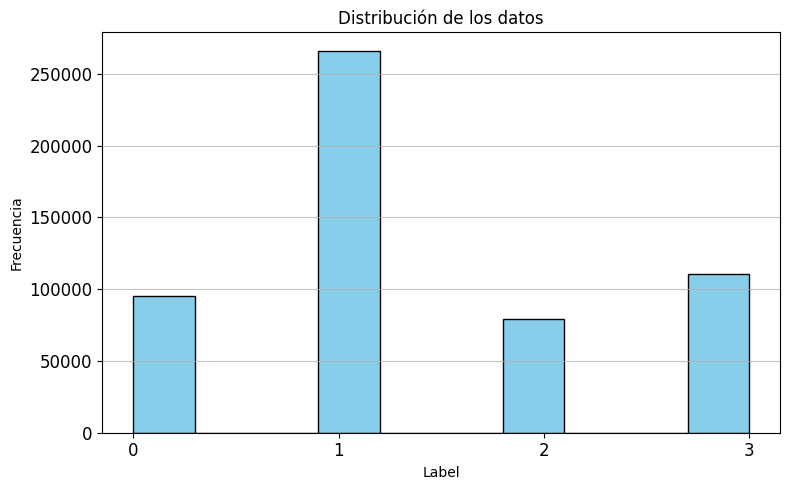

In [ ]:
plotHist(1, (8, 5),
         [[df['Label'].to_numpy(), 10, 'skyblue', 'black', 'Label', 'Frecuencia', 'Distribución de los datos']])

El rango entre 5000 y 10000 tiene significativamente más cantidad de muestras que los otros grupos.  
Por lo que, tomo en cuenta esto para elegir la métrica de evaluación del modelo y sus parámetros.  

## Uso de GPU

Utilizar un entorno de ejecución con GPU.

In [ ]:
print(torch.__version__)

2.4.1+cu121


In [ ]:
device = "cpu"
if torch.cuda.is_available():
  device = "cuda:0"

# Verificar dispositivo correcto
print(device)

cuda:0


## Modelo sin embbedings (Clasificación)

### Preparación de los datos

In [ ]:
def dropColumns(dataframe, columns):
    """
    Función para eliminar columnas del dataset
    en cada instancia de evaluación
    """

    new_df = dataframe.copy()
    for column in columns:
        new_df = new_df.drop(column, axis=1)

    return new_df

En primera instancia, elimino 'User_ID', 'Product_ID' y 'Purchase' que fue ahora reemplazado por 'Label'.  

In [ ]:
df1 = dropColumns (df, ['User_ID', 'Product_ID', 'Purchase'])


Trabajo entonces con el dataset *df1* para esta primera parte con la siguiente estructura:




In [ ]:
df1.head()

,Marital_Status,Gender_encoded,Age_encoded,Stay_In_Current_City_Years_encoded,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,...,Product_Category_3_10.0,Product_Category_3_11.0,Product_Category_3_12.0,Product_Category_3_13.0,Product_Category_3_14.0,Product_Category_3_15.0,Product_Category_3_16.0,Product_Category_3_17.0,Product_Category_3_18.0,Label
0,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,3
2,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,6,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
def separateXY(dataframe, label):
    """
    Separa el conjunto de datos
    en features y target
    """

    df_x = dataframe.drop(label, axis=1)
    df_y =  dataframe[label]

    return df_x, df_y

In [ ]:
# Separarar variable de entrada (x) y target (y)
x1, y1 = separateXY(df1, 'Label')

In [ ]:
x1.sample(5)

,Marital_Status,Gender_encoded,Age_encoded,Stay_In_Current_City_Years_encoded,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,...,Product_Category_3_9.0,Product_Category_3_10.0,Product_Category_3_11.0,Product_Category_3_12.0,Product_Category_3_13.0,Product_Category_3_14.0,Product_Category_3_15.0,Product_Category_3_16.0,Product_Category_3_17.0,Product_Category_3_18.0
505594,1,0,2,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
396422,1,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
324229,1,0,4,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
446014,1,1,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
334257,1,1,5,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
y1.sample(5)

,Label
349719,1
295377,2
93138,1
548389,0
422759,0


In [ ]:
def normToNP(df_x, df_y):
    """
    Función para normalizar y escalar los datos
    Convierte a array de numpy
    y escala entre 0 y 1
    """

    # Convertir los datos a array de numpy
    np_x = df_x.to_numpy(dtype='float')
    np_y = df_y.to_numpy(dtype='float')

    # Escalar los datos de entrada entre 0 y 1 para facilitar la convergencia
    np_x_norm = (np_x - np.min(np_x, axis=0)) / (np.max(np_x, axis=0 ) - np.min(np_x, axis=0))

    return np_x_norm, np_y

In [ ]:
# Convertir los datos a array de numpy y normalizar
x1, y1 = normToNP(x1, y1)

### División del dataset  

Dado que se observa una distribución de clases no homogénea, considero hacer la división del conjunto de datos, asegurando que se mantenga la misma distribución en todos los sub-conjuntos de datos.  
  
Para esto utilizo <i>[StratifiedShuffleSplit](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html)</i> que me asegura:  

* Estratificación: Al dividir los datos, StratifiedShuffleSplit asegura que cada subconjunto (entrenamiento y prueba) tenga una distribución de clases similar a la del conjunto original.

* Aleatoriedad: La técnica mezcla los datos de manera aleatoria, garantizando que la selección de muestras sea al azar, pero siempre respetando la proporción de clases.

In [ ]:
def getSSS(n_splits, test_size, random_state, x, y, df=False):
    """
    Función para dividir el conjunto de datos en dos
    manteniendo la distribución de los datos
    """

    splitter = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)

    for idx1, idx2 in splitter.split(x, y):
        if df:
          x_1, x_2 = x.iloc[idx1], x.iloc[idx2]
          y_1, y_2 = y.iloc[idx1], y.iloc[idx2]
        else:
          x_1, x_2 = x[idx1], x[idx2]
          y_1, y_2 = y[idx1], y[idx2]

    return x_1, y_1, x_2, y_2

In [ ]:
# Dividir manteniendo la relación de clases

# Entrenamiento y Validación
train_x1, train_y1, valid_x1, valid_y1 = getSSS(n_splits=1, test_size=0.30, random_state=42, x=x1, y=y1)

In [ ]:
def printSampleNum(df_total, df_arr, percent):
    """
    Función para verificar
    cómo quedan divididas las muestras
    """

    n_df = df_total.shape[0]
    print("Cantidad de muestras:\n")

    for ds, name  in df_arr:

        if isinstance(ds, np.ndarray):
            n_d = ds.shape[0]
        else:
            n_d = len(ds)

        if percent:
            p = f"({(n_d/n_df)*100:.0f}%)"
        else:
            p = ""

        print(f"- {name}: {n_d} {p}")

El dataset queda entonces dividido en Entrenamiento y Validación, de la siguiente forma:

In [ ]:
printSampleNum(x1, [[train_x1, 'Entrenamiento'],
                   [valid_x1, 'Validación']], True)

Cantidad de muestras:

- Entrenamiento: 385047 (70%)
- Validación: 165021 (30%)


In [ ]:
# Tamaño del set de entrenamiento
n_train = train_x1.shape[0]

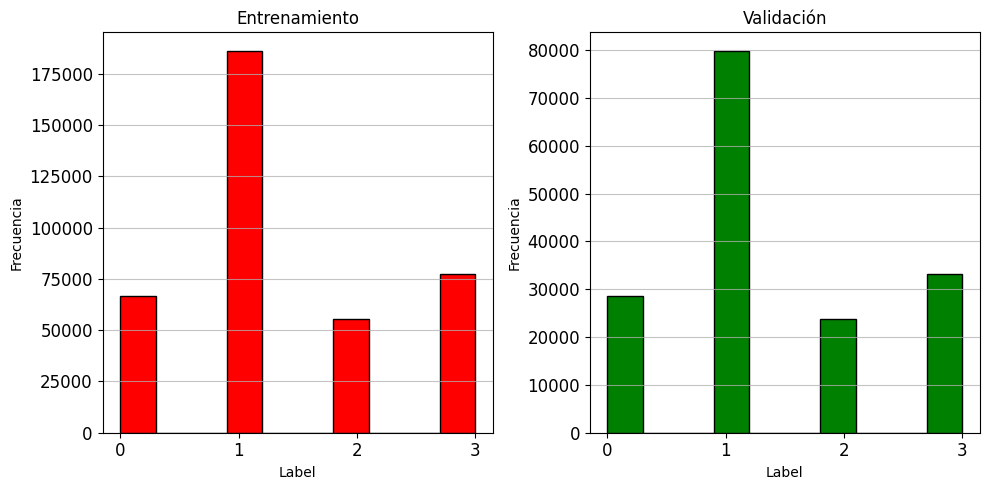

In [ ]:
# Graficar histograma por subset

plotHist(2, (10, 5),
         [[train_y1, 10, 'red', 'black', 'Label', 'Frecuencia', 'Entrenamiento'],
         [valid_y1, 10, 'green', 'black', 'Label', 'Frecuencia', 'Validación']])

Compruebo que se mantiene la misma distribución de los datos que presentaba el conjunto de datos original en cada una de las particiones, asegurándome así la representatividad del análisis.

Decido no equilibrar las clases y mantener el desbalance, ya que, al tratarse de montos de compras, es razonable que esta distribución represente la realidad y no sea un sesgo de la muestra.  


### Parámetros e Hiperparámetros

Inicializo los diferentes parámetros e hiperparámetros que usará el modelo para luego realizar los diferentes experimentos variando estos valores.

In [ ]:
# Tamaño inicial del batch
batch_size = 64

# Cantidad de características de entrada
n_features = train_x1.shape[1]

# Cantidad de neuronas por capa intermedia
n_neurons = [128, 64, 32]

# Cantidad de capas intermedias (entre entrada y salida)
n_layers = len(n_neurons)

# Cantidad de salidas (4 -> una por clase)
output = len(np.unique(train_y1))

# % drop out
drop_out = 0.2

# Cantidad de épocas
epochs = 100

# Learning Rate
learning_rate = 0.01

### Datasets en Pytorch

Defino una clase MyDataset, que hereda de Dataset, implementación básica para crear un conjunto de datos personalizado en PyTorch.  

In [ ]:
# Definición del dataset
class MyDataset(Dataset):

  #__init__ guarda el dataset en una variable de clase
  def __init__(self, x, y):
    self.x = x
    self.y = y

  # __len__ define el comportamiento de la función len() sobre el objeto
  def __len__(self):
    return self.x.shape[0]

  # __getitem__ define el comportamiento de los []
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [ ]:
# Inicialización de los datasets
train_ds = MyDataset(train_x1, train_y1)
valid_ds = MyDataset(valid_x1, valid_y1)

printSampleNum(x1, [[train_ds, 'Entrenamiento'],
                   [valid_ds, 'Validación']], True)


Cantidad de muestras:

- Entrenamiento: 385047 (70%)
- Validación: 165021 (30%)


Dataloaders para cada uno de los subconjuntos de datos.  

Para garantizar aleatoriedad uso el parámetro *shuffle=True* en el caso del conjunto de datos de entrenamiento.  
De esta forma el DataLoader mezcla los datos al inicio de cada época ayudando a que el modelo no aprenda patrones en el orden de los datos.

No utilizo *shuffle=True* para el conjunto de validación, ya que no es necesario que los datos se mezclen, solo evaluar el rendimiento del modelo.  

In [ ]:
# Dataloaders para cada set
train_dataloader = DataLoader(train_ds, batch_size = batch_size, shuffle= True)
valid_dataloader = DataLoader(valid_ds, batch_size=batch_size)


### Arquitectura de la red

Defino la clase NNet con una arquitectura sencilla y parametrizable para poder hacer diferentes pruebas.

* La cantidad de neuronas de las capas se recibe por parámetro.
* La capa de entrada es lineal con la cantidad de características recibida por parámetro.
* Las capas intermedias son lineales con ReLu como función de activación (1).
* La cantidad de capas intermedias se controla también por parámetro en la función forward.
* La capa de salida también es lineal, con una neurona por clase.
* La aplicación de dropout se controla también por parámetro (por defecto =0, sin dropout) (2)
  
  
  
(1) ReLU puede ayudar a mitigar el problema del desvanecimiento del gradiente y es rápida de calcular, en comparación con otras funciones de activación, ya que solo implica una comparación y no requiere operaciones exponenciales.  
  
(2) Utilizo dropout como técnica de regularización para prevenir el sobreajuste del modelo.  La desactivación aleatoria de un porcentaje de neuronas en la capa (según la probabilidad ingresada por parámetro), ayuda al modelo a no depender de ninguna neurona en particular, promoviendo un aprendizaje más robusto.

In [ ]:
class NNet(torch.nn.Module):

  def __init__(self, in_features, layers, n_neurons, output, drop_out=0):

    # Inicialización
    super().__init__()

    # Capa de entrada
    self.inputs = torch.nn.Linear(in_features=in_features, out_features=n_neurons[0], bias=True)

    # Capas intermedias
    self.layers = layers
    self.hidden_layers = torch.nn.ModuleList()
    for i in range(len(n_neurons) - 1):
        self.hidden_layers.append(torch.nn.Linear(in_features=n_neurons[i], out_features=n_neurons[i + 1], bias=True))

    # ReLU como función de activación en las capas intermedias
    self.relu = torch.nn.ReLU()

    # Drop out según % indicado por parámetro
    self.dropout = torch.nn.Dropout(p = drop_out)

    # Capa de salida
    self.outputs = torch.nn.Linear(in_features=n_neurons[-1], out_features=output, bias=True)


  def forward(self, x):

    # Paso forward

    # Capa de entrada
    x = self.inputs(x)
    x = self.relu(x)
    x =  self.dropout(x)

    # Capas intermedias
    for hidden_layer in self.hidden_layers:
      x = hidden_layer(x)
      x = self.relu(x)
      x = self.dropout(x)

    # Salida
    x = self.outputs(x)

    return x

### Función de pérdida

Dado que se trata de un problema de clasificación de varias clases, utilizo [CrossEntropyLoss](https://pytorch.org/docs/2.4/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss).

No es necesario aplicar Softmax para la salida, y tampoco es necesario aplicar encoding sobre el Label, ya que esta función de Pytorch aplica ambas cosas internamente.  
  
Dado que las clases están desbalanceadas, aplico pesos para el entrenamiento en función de la frecuencia de ocurrencias de cada clase.  


Para ajustar los pesos, los calculo inversamente proporcionales a la frecuencia de cada clase.   
Esto ayuda a que el modelo preste más atención a las clases menos representadas durante el entrenamiento.

In [ ]:
# Número total de muestras
total_samples = train_y1.shape[0]
# Número de clases
num_classes = output
# Contar ocurrencias
unique_values, counts = np.unique(train_y1, return_counts=True)
# Calcular las proporciones
class_proportions = torch.tensor(counts/total_samples, dtype=torch.float32)

# Calcular pesos
class_weights = [1.0 / p for p in class_proportions]
# Normalizar los pesos
class_weights = [weight / sum(class_weights) for weight in class_weights]

# Con pesos para compensar desbalance
class_weights = torch.tensor(class_weights)
class_weights = class_weights.to(device)
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights)

print(class_proportions)
print(class_weights)

tensor([0.1726, 0.4830, 0.1435, 0.2009])
tensor([0.2925, 0.1045, 0.3518, 0.2512], device='cuda:0')


### Métricas de evaluación

**Accuracy** (Exactitud)  
Es la proporción de predicciones correctas entre el total de predicciones realizadas.  
  
*(Verdaderos Positivos + Verdaderos Negativos) / Total Predicciones*

**Precision** (Precisión)  
Es la proporción de verdaderos positivos entre todas las instancias que fueron clasificadas como positivas.    
  
*Verdaderos Positivos / (Verdadederos Positivos + Falsos Positivos)*
  
**Recall** (Sensibilidad)  
Es la proporción de verdaderos positivos entre todas las instancias que realmente son positivas.  
  
*Verdaderos Positivos / (Verdaderos Positivos + Falsos Negativos)*
  
**F1-Score**  
Es la media armónica de la precisión y el recall.  
La métrica F1 es útil especialmente en situaciones como ésta donde hay un desbalance en las clases.   
Combina la precisión y el recall en un solo valor, proporcionando una visión más equilibrada del rendimiento del modelo.

Para clasificación multiclase, las métricas se calculan generalmente usando promedios "micro" o "macro".

Micro promedio: Calcula las métricas globalmente considerando todos los ejemplos y todas las clases.

Macro promedio: Calcula las métricas para cada clase de forma independiente y luego promedia los resultados.

Dado que la clase mayoritaria representa casi el 50% de los datos, el micro promedio podría dar un resultado muy positivo, ya que su rendimiento influiría más en la métrica general.

Las clases 2 y 3 representan clientes con compras de mayor monto, por lo que, interesan en el contexto del problema.

Es por esto que, decido utilizar la opción 'macro' para verificar el rendimiento en todas las clases, especialmente en las que son menos representadas, ya que corresponden en su mayoría a segmentos valiosos de clientes.

In [ ]:
def compute_metrics(preds, labels):
    """
    Función para calcular las métricas
    de un problema de clasificación multiclase
    """

    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()

    accuracy = accuracy_score(labels, preds)
    precision_macro = precision_score(labels, preds, average='macro', zero_division=0)
    recall_macro = recall_score(labels, preds, average='macro', zero_division=0)
    f1_macro = f1_score(labels, preds, average='macro', zero_division=0)

    return accuracy, precision_macro, recall_macro, f1_macro


Tomo como línea base una heurística que implica predecir siempre el valor de la clase más probable (1).  

Por lo tanto, tomando una muestra de 385047 observaciones (set de entrenamiento), según la distribución de los datos, resultaría:  
- 0: 66459 (17,26%)
- 1: 185978 (48,30%)
- 2: 55254 (14,35%)
- 3: 77356 (20,09%)

Si siempre predigo la clase 1, el Accuracy resultaría en 48.3%.

Sin embargo, tratándose de un conjunto desbalanceado, decido evaluar las cuatro métricas para tener una visión más clara del comportamiento sobre todo el universo de los datos.


### Optimizador

Para optimizar utilizo [Adam](https://pytorch.org/docs/2.4/generated/torch.optim.Adam.html#adam), en principio con sus parámetros por default, modificando únicamente el *Learning Rate*.
  
*Adam* adapta la tasa de aprendizaje para cada parámetro, lo que puede resultar en un entrenamiento más eficiente, combinando las ventajas de otros optimizadores.

### Ejecución

Defino la siguiente función para ejecutar la red neuronal en modo entrenamiento y validación y poder variar parámetros durante los experimentos preliminares.  


In [ ]:
def processNNet(model, optimizer, loss_f, epochs, t_dataloader, v_dataloader, embeddings=False, verbose=False):
  """
  model: modelo a entrenar o evaluar
  optimizer: optimizador a utilizar
  loss: función de costo a utilizar
  epochs: Número de épocas a ejecutar
  t_dataloader/v_dataloader: Dataloader del set a ejecutar train y test
  embeddings: Si los datos incluyen embeddings o no
  verbose: True/False - Imprime por pantalla detalles de cada época
  """

  global device

  t_loss_by_epoch = []
  t_acc_by_epoch = []
  t_prec_by_epoch = []
  t_rec_by_epoch = []
  t_f1_by_epoch = []

  v_loss_by_epoch = []
  v_acc_by_epoch = []
  v_prec_by_epoch = []
  v_rec_by_epoch = []
  v_f1_by_epoch = []

  for epoch in range(epochs):

    if verbose:
        print(f'Nro. época: {epoch + 1}/{epochs}')

    # MODO ENTRENAMIENTO
    model.train()

    t_epoch_loss = 0
    t_epoch_y_hat = []
    t_epoch_y = []

    for i, data in enumerate(t_dataloader):

      if embeddings:
        # Datos del batch con embeddings
        x_batch, user_embed_batch, product_embed_batch, y_batch = data

        # Copia embeddings al device disponible
        user_embed_batch = user_embed_batch.to(device).int()
        product_embed_batch = product_embed_batch.to(device).int()

      else:
        # Datos del batch sin embeddings
        x_batch, y_batch = data

      # Copia al device disponible
      x_batch = x_batch.to(device).float()
      y_batch = y_batch.to(device).long()

      # Resetear gradientes sólo en train
      optimizer.zero_grad()

      if embeddings:
        y_batch_hat = model(x_batch, user_embed_batch, product_embed_batch)
      else:
        y_batch_hat = model(x_batch)

      # Función de costo
      loss = loss_f(y_batch_hat, y_batch)

      # Backpropagation sólo en train
      loss.backward()
      # Actualizar los parámetros
      optimizer.step()

      # Guardar datos
      t_epoch_loss = t_epoch_loss + loss.item()

      # Obtener predicciones de clase
      preds = torch.argmax(y_batch_hat, dim=1)

      # Acumular las métricas
      t_epoch_y_hat.extend(preds.cpu().numpy())
      t_epoch_y.extend(y_batch.cpu().numpy())


    # Calcular la media de la loss por época para graficar
    t_epoch_loss = t_epoch_loss / len(t_dataloader)
    t_loss_by_epoch.append(t_epoch_loss)

    # Calcular la métricas para la época
    acc, prec, rec, f1 = compute_metrics(torch.tensor(t_epoch_y_hat), torch.tensor(t_epoch_y))

    if verbose:
        print(f"Entrenamiento")
        print(f'Loss: {t_epoch_loss:.4f}, Accuracy = {acc:.4f}, Precision = {prec:.4f}, Recall = {rec:.4f}, F1 = {f1:.4f}')

    # Acumular para graficar por época
    t_acc_by_epoch.append(acc)
    t_prec_by_epoch.append(prec)
    t_rec_by_epoch.append(rec)
    t_f1_by_epoch.append(f1)

    # MODO VALIDACION
    model.eval()

    v_epoch_loss = 0
    v_epoch_y_hat = []
    v_epoch_y = []

    for i, data in enumerate(v_dataloader):

      if embeddings:
        # Datos del batch con embeddings
        x_batch, user_embed_batch, product_embed_batch, y_batch = data

        # Copia embeddings al device disponible
        user_embed_batch = user_embed_batch.to(device).int()
        product_embed_batch = product_embed_batch.to(device).int()

      else:
        # Datos del batch sin embeddings
        x_batch, y_batch = data

      # Copia al device disponible
      x_batch = x_batch.to(device).float()
      y_batch = y_batch.to(device).long()

      if embeddings:
        y_batch_hat = model(x_batch, user_embed_batch, product_embed_batch)
      else:
        y_batch_hat = model(x_batch)

      # Función de costo
      loss = loss_f(y_batch_hat, y_batch)

      # Guardar datos
      v_epoch_loss = v_epoch_loss + loss.item()

      # Obtener predicciones de clase
      preds = torch.argmax(y_batch_hat, dim=1)

      # Acumular las métricas
      v_epoch_y_hat.extend(preds.cpu().numpy())
      v_epoch_y.extend(y_batch.cpu().numpy())


    # Calcular la media de la loss por época para graficar
    v_epoch_loss = v_epoch_loss / len(v_dataloader)
    v_loss_by_epoch.append(v_epoch_loss)

    # Calcular la métricas para la época
    acc, prec, rec, f1 = compute_metrics(torch.tensor(v_epoch_y_hat), torch.tensor(v_epoch_y))

    if verbose:
        print(f'Validación')
        print(f'Loss: {v_epoch_loss:.4f}, Accuracy = {acc:.4f}, Precision = {prec:.4f}, Recall = {rec:.4f}, F1 = {f1:.4f}\n')

    # Acumular para graficar por época
    v_acc_by_epoch.append(acc)
    v_prec_by_epoch.append(prec)
    v_rec_by_epoch.append(rec)
    v_f1_by_epoch.append(f1)

  return (t_loss_by_epoch, t_acc_by_epoch, t_prec_by_epoch, t_rec_by_epoch, t_f1_by_epoch,
          v_loss_by_epoch, v_acc_by_epoch, v_prec_by_epoch, v_rec_by_epoch, v_f1_by_epoch)

In [ ]:
# Instancia de la red
nnet = NNet(n_features, n_layers, n_neurons, output, drop_out)
nnet.to(device)
print(nnet)

NNet(
  (inputs): Linear(in_features=77, out_features=128, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (outputs): Linear(in_features=32, out_features=4, bias=True)
)


In [ ]:
optimizer = torch.optim.Adam(nnet.parameters(), lr=learning_rate)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


In [ ]:
print(f"Cantidad de parámetros a optimizar: {sum(p.numel() for p in nnet.parameters())}")

Cantidad de parámetros a optimizar: 20452


In [ ]:
def graphCurves(n_subplots, figsize, x_vals, graphs):
    """
    Función para graficar las curvas de resultado
    """

    fig, axs = plt.subplots(1, n_subplots, figsize=figsize)

    for i , graph  in enumerate(graphs):

        if n_subplots > 1:
            ax = axs[i]
        else:
            ax =axs

        for y, xlabel, ylabel, yseries, title in graph:

            ax.plot(x_vals, y, label=yseries)
            ax.set_xlabel(xlabel,  fontsize=10)
            ax.set_ylabel(ylabel, fontsize=10)

        ax.set_title(title, fontsize=10)
        ax.grid(axis='y', alpha=0.75)
        ax.tick_params(axis='both', labelsize=10)
        ax.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
nnet = nnet.to(device)

(
    train_loss_by_epoch, train_acc_by_epoch, train_prec_by_epoch, train_rec_by_epoch, train_f1_by_epoch,
    valid_loss_by_epoch, valid_acc_by_epoch, valid_prec_by_epoch, valid_rec_by_epoch, valid_f1_by_epoch

) = processNNet(nnet, optimizer, loss_function, epochs, train_dataloader, valid_dataloader, embeddings=False, verbose=True)

Nro. época: 1/100
Entrenamiento
Loss: 0.8358, Accuracy = 0.6925, Precision = 0.6410, Recall = 0.6225, F1 = 0.6160
Validación
Loss: 0.8174, Accuracy = 0.6927, Precision = 0.6624, Recall = 0.6259, F1 = 0.6275

Nro. época: 2/100
Entrenamiento
Loss: 0.8316, Accuracy = 0.6948, Precision = 0.6454, Recall = 0.6226, F1 = 0.6159
Validación
Loss: 0.8123, Accuracy = 0.7129, Precision = 0.6806, Recall = 0.6335, F1 = 0.6242

Nro. época: 3/100
Entrenamiento
Loss: 0.8305, Accuracy = 0.6947, Precision = 0.6460, Recall = 0.6227, F1 = 0.6155
Validación
Loss: 0.8079, Accuracy = 0.6779, Precision = 0.6628, Recall = 0.6150, F1 = 0.6146

Nro. época: 4/100
Entrenamiento
Loss: 0.8301, Accuracy = 0.6960, Precision = 0.6485, Recall = 0.6237, F1 = 0.6149
Validación
Loss: 0.8121, Accuracy = 0.7106, Precision = 0.6754, Recall = 0.6321, F1 = 0.6216

Nro. época: 5/100
Entrenamiento
Loss: 0.8320, Accuracy = 0.6959, Precision = 0.6479, Recall = 0.6224, F1 = 0.6120
Validación
Loss: 0.8173, Accuracy = 0.6752, Precision 

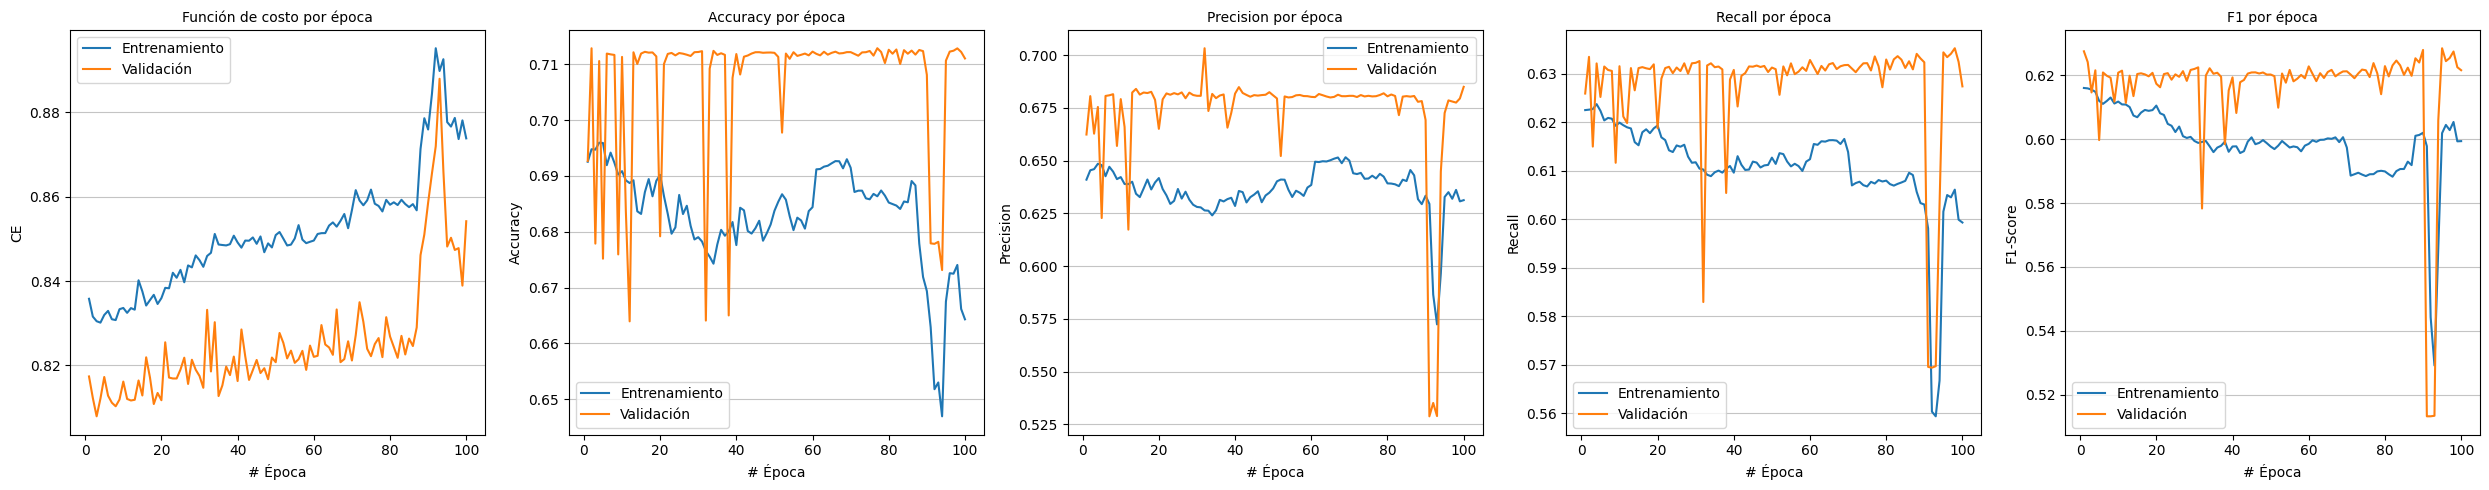

In [ ]:
# Graficar el resultado
x_epochs = list(range(1, epochs + 1))
graphCurves(5, (25, 5), x_epochs, [
    [[train_loss_by_epoch, '# Época', 'CE', 'Entrenamiento', 'Función de costo por época'],
     [valid_loss_by_epoch, '# Época', 'CE', 'Validación', 'Función de costo por época']],
    [[train_acc_by_epoch, '# Época', 'Accuracy', 'Entrenamiento', 'Accuracy por época'],
     [valid_acc_by_epoch, '# Época', 'Accuracy', 'Validación', 'Accuracy por época']],
    [[train_prec_by_epoch, '# Época', 'Precision', 'Entrenamiento', 'Precision por época'],
     [valid_prec_by_epoch, '# Época',  'Precision', 'Validación', 'Precision por época']],
    [[train_rec_by_epoch, '# Época', 'Recall', 'Entrenamiento', 'Recall por época'],
     [valid_rec_by_epoch, '# Época',  'Recall', 'Validación', 'Recall por época']],
    [[train_f1_by_epoch, '# Época', 'F1-Score', 'Entrenamiento', 'F1 por época'],
     [valid_f1_by_epoch, '# Época',  'F1-Score', 'Validación', 'F1 por época']]
])



### Matriz de confusión

Para entender el comportamiento del modelo prediciendo las diferentes clases, grafico la matriz de confusión:

In [ ]:
# Etiquetas verdaderas
labels = []
for inputs, targets in valid_dataloader:
    labels.append(targets.cpu().numpy())
labels = np.concatenate(labels)

# Predicciones
preds = []
nnet.eval()
with torch.no_grad():

    for inputs, _ in valid_dataloader:
        inputs = inputs.to(device).float()
        outputs = nnet(inputs)
        # Obtiene la clase con la máxima probabilidad
        _, predicted = torch.max(outputs, 1)
        preds.append(predicted.cpu().numpy())
preds = np.concatenate(preds)


In [ ]:
unique, counts = np.unique(preds, return_counts=True)
pred_distribution = dict(zip(unique, counts))
print(pred_distribution)

{0: 13485, 1: 81776, 2: 16063, 3: 53697}


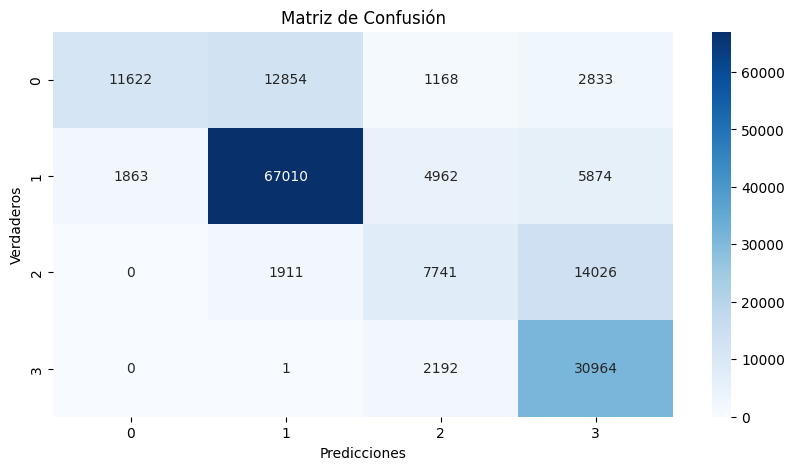

In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(labels, preds)

# Configurar el tamaño de la figura
plt.figure(figsize=(10, 5))

# Crear un mapa de calor para la matriz de confusión
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1', '2', '3'],
            yticklabels=['0', '1', '2', '3'])

plt.xlabel('Predicciones')
plt.ylabel('Verdaderos')
plt.title('Matriz de Confusión')
plt.show()


Sobre la diagonal principal las predicciones correctas (instancias de cada clase que fueron clasificadas correctamente).  

Fuera de la Diagonal las instancias que fueron clasificadas incorrectamente.


### Conclusiones

Realicé varios experimentos cambiando los parámetros de la clase *NNet* para variar la arquitectura de la red y también los parámetros de la función *processNNet*.
  
Escenarios con un learning rate alto, provocaban que el modelo oscilara y no llegara a una convergencia.  Por lo tanto, decidí utilizar un valor más bajo para este hiperparámetro del optimizer.

Arquitecturas más sencillas con menos capas y neuronas, o bien, menos épocas, provocaban que el modelo no llegara a captar la complejidad de los datos, por lo que, decidí incrementar la cantidad de capas.

Con una arquitectura de tres capas, regularización por drop out, el modelo no logra aprender, ya que se observa que la curva de la función de pérdida no decrece:  
  
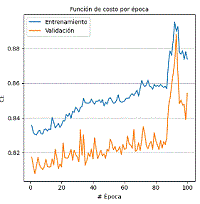
  
  
Además la matriz de confusión muestra una gran cantidad de predicciones incorrectas.  

Para mejorar los resultados, debería aumentar la complejidad del modelo hasta lograr que aprenda.  En caso de llegar a un overfitting por exceso de complejidad, las técnicas de regularización podrían ayudar a que el modelo aprenda patrones importantes y generalice correctamente.  
  
Dado que la forma correcta de encarar el problema es con Embeddings, avanzo al punto siguiente para así luego aplicar eventualmente más opciones de regularización para mejorar el desempeño del modelo final.



## Modelo con Embeddings (Clasificación)

### Preparación de los datos

En este caso, elimino todas las columnas de Product_Category (tanto las originales como las generadas por One Hot Encoding).  

Esto porque, la relación de categorías y id de producto es uno a uno, con lo cual, ya incluyo la información del producto al incluir embedding del Product_ID.  

In [ ]:
df2 = dropColumns (df, ['User_ID', 'Product_ID', 'Purchase'])
# Dado que el modelo incluirá el Product_ID, elimino todas las columnas de Product_Category
df2 = dropColumns (df2, df2.filter(like='Product_Category').columns)

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 27 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Marital_Status                      550068 non-null  int64
 1   Gender_encoded                      550068 non-null  int64
 2   Age_encoded                         550068 non-null  int64
 3   Stay_In_Current_City_Years_encoded  550068 non-null  int64
 4   Occupation_1                        550068 non-null  int64
 5   Occupation_2                        550068 non-null  int64
 6   Occupation_3                        550068 non-null  int64
 7   Occupation_4                        550068 non-null  int64
 8   Occupation_5                        550068 non-null  int64
 9   Occupation_6                        550068 non-null  int64
 10  Occupation_7                        550068 non-null  int64
 11  Occupation_8                        550068 non-null 

### Embeddings

Creo la representación en vectores numéricos para usuario y producto, para poder captar las relaciones incluyendo estos elementos.

In [ ]:
# Embeddings para User_ID
user_id = df['User_ID']
n_user_id = len(user_id.unique())

print(n_user_id)
print(user_id.unique())

# Transformar id a indices (idx) consecutivos para utilizar embeddings
user_id_to_idx = {value:i for i, value in enumerate(user_id.unique())}

# Vector de idx en el dataset
user_idx = np.array([user_id_to_idx[value] for value in user_id])

5891
[1000001 1000002 1000003 ... 1004113 1005391 1001529]


In [ ]:
# Embeddings para Product_ID
product_id = df['Product_ID']
n_product_id = len(product_id.unique())

print(n_product_id)
print(product_id.unique())

# Transformar id a indices (idx) consecutivos para utilizar embeddings
product_id_to_idx = {value:i for i, value in enumerate(product_id.unique())}

# Vector de idx en el dataset
product_idx = np.array([product_id_to_idx[value] for value in product_id])

3631
['P00069042' 'P00248942' 'P00087842' ... 'P00370293' 'P00371644'
 'P00370853']


Defino para este caso una nueva clase *MyDatasetWithEmbddings* que incluya los embeddings generados.

In [ ]:
# Clase Dataset de Pytorch con embeddings
class MyDatasetWithEmbddings(Dataset):

  def __init__(self, x, user_idx, product_idx, y):
    self.x = x
    self.user_idx = user_idx
    self.product_idx = product_idx
    self.y = y

  def __len__(self):
    return self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.user_idx[idx], self.product_idx[idx], self.y[idx]

Para determinar el tamaño inicial de los embeddings exploro si existe algún tipo de correlación entre los atributos.

In [ ]:
#df0 Línea Base
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [ ]:
df_corr = dropColumns (df0, df0.filter(like='Product_Category').columns)

df_corr['Gender'] = (df_corr['Gender'].map({'M': 1, 'F': 0})).astype(int)
df_corr['Age'] = (df_corr['Age'].map(age_mapping)).astype(int)
df_corr['City_Category'] = (df_corr['City_Category'].map({'A': 0, 'B': 1, 'C': 2})).astype(int)
df_corr['Stay_Years'] = (df_corr['Stay_In_Current_City_Years'].map(stay_mapping)).astype(int)
df_corr = dropColumns (df_corr, ['Stay_In_Current_City_Years'])
df_corr['Product_ID'] = df_corr['Product_ID'].apply(lambda x: int(x[1:]))

df_corr.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   User_ID         550068 non-null  int64
 1   Product_ID      550068 non-null  int64
 2   Gender          550068 non-null  int64
 3   Age             550068 non-null  int64
 4   Occupation      550068 non-null  int64
 5   City_Category   550068 non-null  int64
 6   Marital_Status  550068 non-null  int64
 7   Purchase        550068 non-null  int64
 8   Stay_Years      550068 non-null  int64
dtypes: int64(9)
memory usage: 37.8 MB


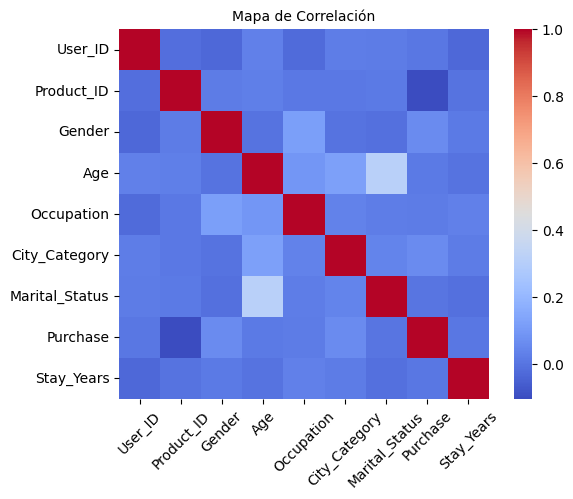

In [ ]:
# Calcular la matriz de correlación
correlation_matrix = df_corr.corr()

# Crear el mapa de calor
plt.figure()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Mapa de Correlación', fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.show()

Decido utilizar tamaños diferentes para cada uno de los embeddings.  

En principio, utilizando una regla general en función de la cantidad de valores únicos que tiene cada uno, para intentar no perder información y evitar que el modelo no logre capturar adecuadamente la complejidad de las relaciones por utilizar un tamaño de embedding muy pequeño.

En función de los resultados, se puede luego reducir el tamaño sin afectar el buen desempeño del modelo, y de esa forma reducir el costo computacional.


In [ ]:
user_embedding_dim = int(n_user_id**0.5)
product_embedding_dim = int(n_product_id**0.5)

print(f"Tamaño User Embedding: {user_embedding_dim}")
print(f"Tamaño Product Embedding: {product_embedding_dim}")


Tamaño User Embedding: 76
Tamaño Product Embedding: 60


### División del dataset

In [ ]:
# Separarar variable de entrada (x) y target (y)
x2, y2 = separateXY(df2, 'Label')

In [ ]:
x2_embeddings = pd.DataFrame({'user_idx': user_idx, 'product_idx': product_idx})
x2_to_split = pd.concat([x2, x2_embeddings], axis=1)

In [ ]:
# Entrenamiento y validación
train_x2_w_emb, train_y2, valid_x2_w_emb, valid_y2 = getSSS(n_splits=1, test_size=0.30, random_state=42, x=x2_to_split, y=y2, df=True)

In [ ]:
train_x2_user, df_train_product_idx = separateXY(train_x2_w_emb, 'product_idx')
train_x2, df_train_user_idx = separateXY(train_x2_user, 'user_idx')

valid_x2_user, df_valid_product_idx = separateXY(valid_x2_w_emb, 'product_idx')
valid_x2, df_valid_user_idx = separateXY(valid_x2_user, 'user_idx')

In [ ]:
# Convertir los datos a array de numpy y normalizar
train_x2, train_y2 = normToNP(train_x2, train_y2)
valid_x2, valid_y2 = normToNP(valid_x2, valid_y2)

user_idx_train = np.array(df_train_user_idx)
user_idx_valid = np.array(df_valid_user_idx)
product_idx_train = np.array(df_train_product_idx)
product_idx_valid = np.array(df_valid_product_idx)

printSampleNum(x2, [[train_x2, 'Entrenamiento'],
                   [valid_x2, 'Validación']], True)

Cantidad de muestras:

- Entrenamiento: 385047 (70%)
- Validación: 165021 (30%)


In [ ]:
# Tamaño del set de entrenamiento
n_train = train_x2.shape[0]

In [ ]:
# Embeddings y Dataloaders
train_ds_embeddings = MyDatasetWithEmbddings(train_x2,
                                             user_idx_train,
                                             product_idx_train,
                                             train_y2)

valid_ds_embeddings = MyDatasetWithEmbddings(valid_x2,
                                             user_idx_valid,
                                             product_idx_valid,
                                             valid_y2)

train_dataloader_emb = DataLoader(train_ds_embeddings, batch_size = batch_size, shuffle= True)
valid_dataloader_emb = DataLoader(valid_ds_embeddings, batch_size = batch_size)

### Arquitectura de la red

En este caso defino la clase *NNetWithEmbeddings* para incluir en la arquitectura las capas de embeddings.

Mantengo los mismos parámetros de la clase original sin embeddings, agregando en este caso que, se reciben también por parámetro los embeddings y sus dimensiones.

La capa inicial entonces, recibe una cantidad de features igual a la suma de características más la dimensión de ambos embeddings.  

La capa de salida sigue siendo igual que en el modelo anterior con la misma función de costo para clasificación no binaria.

In [ ]:
# Arquitectura con embeddings
class NNetWithEmbeddings(torch.nn.Module):

  def __init__(self, in_features, n_layers, n_neurons, output, drop_out,
               user_embeddings, product_embeddings, user_embedding_dim, product_embedding_dim):

    super().__init__()
    self.user_embeddings = torch.nn.Embedding(num_embeddings=user_embeddings, embedding_dim=user_embedding_dim)
    self.product_embeddings = torch.nn.Embedding(num_embeddings=product_embeddings, embedding_dim=product_embedding_dim)

    self.linear = torch.nn.Linear(in_features= (in_features + user_embedding_dim + product_embedding_dim),
                                  out_features=n_neurons[0], bias=True)

    self.relu = torch.nn.ReLU()

    # Drop out según % indicado por parámetro
    self.dropout = torch.nn.Dropout(p = drop_out)

    # Capas intermedias
    self.layers = n_layers
    self.hidden_layers = torch.nn.ModuleList()
    for i in range(len(n_neurons) - 1):
        self.hidden_layers.append(torch.nn.Linear(in_features=n_neurons[i], out_features=n_neurons[i + 1], bias=True))

    self.output = torch.nn.Linear(in_features = n_neurons[-1], out_features= output, bias=True)


  def forward(self, x, user_idx, product_idx):

    user_embedded = self.user_embeddings(user_idx)
    product_embedded = self.product_embeddings(product_idx)

    # Concatenar las embeddings
    x = torch.cat((x, user_embedded, product_embedded), dim=1)

    x = self.linear(x)
    x = self.relu(x)
    x = self.dropout(x)

    # Capas intermedias
    for hidden_layer in self.hidden_layers:
      x = hidden_layer(x)
      x = self.relu(x)
      x = self.dropout(x)

    x = self.output(x)

    return x

Para los parámetros del experimento agrego *weight_decay*, que es una forma de regularización L2.  

A medida que se actualizan los pesos del modelo durante el entrenamiento, se añade una penalización a la función de pérdida que es proporcional al cuadrado de la magnitud de los pesos. Esto ayuda a mantener los pesos más pequeños y evita que se ajusten demasiado a los datos de entrenamiento.

Esto ayuda entonces a prevenir el sobreajuste y a mejorar la generalización del modelo.

In [ ]:
# Cantidad de características de entrada
n_features = train_x2.shape[1]

# Cantidad de neuronas por capa
n_neurons = [128, 64, 32]

# Cantidad de capas intermedias (entre entrada y salida)
n_layers = len(n_neurons)

# % drop out
drop_out = 0.2

# Cantidad de épocas
epochs = 100

# Learning Rate
learning_rate = 0.001

# Weight Decay
weight_decay = 0.01

In [ ]:
nnnetWithEmbeddings = NNetWithEmbeddings(n_features, n_layers, n_neurons, output, drop_out,
               n_user_id, n_product_id, user_embedding_dim, product_embedding_dim)

nnnetWithEmbeddings = nnnetWithEmbeddings.to(device)

# loss_function => Misma del punto anterior ya instanciada

# Optimizador con regularización L2 (parámetro weight_decay)
optimizer = torch.optim.Adam(nnnetWithEmbeddings.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [ ]:
print(nnnetWithEmbeddings)

NNetWithEmbeddings(
  (user_embeddings): Embedding(5891, 76)
  (product_embeddings): Embedding(3631, 60)
  (linear): Linear(in_features=162, out_features=128, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
  )
  (output): Linear(in_features=32, out_features=4, bias=True)
)


In [ ]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)


### Ejecución

In [ ]:
nnnetWithEmbeddings = nnnetWithEmbeddings.to(device)

nnet = nnet.to(device)

(
    train_loss_by_epoch, train_acc_by_epoch, train_prec_by_epoch, train_rec_by_epoch, train_f1_by_epoch,
    valid_loss_by_epoch, valid_acc_by_epoch, valid_prec_by_epoch, valid_rec_by_epoch, valid_f1_by_epoch

) = processNNet(nnnetWithEmbeddings, optimizer, loss_function, epochs, train_dataloader_emb, valid_dataloader_emb, embeddings=True, verbose=True)


Nro. época: 1/100
Entrenamiento
Loss: 1.1328, Accuracy = 0.4274, Precision = 0.4173, Recall = 0.4382, F1 = 0.4067
Validación
Loss: 0.9404, Accuracy = 0.4394, Precision = 0.5071, Recall = 0.5449, F1 = 0.4536

Nro. época: 2/100
Entrenamiento
Loss: 0.9379, Accuracy = 0.4826, Precision = 0.5248, Recall = 0.5590, F1 = 0.4926
Validación
Loss: 0.9034, Accuracy = 0.4955, Precision = 0.5501, Recall = 0.5787, F1 = 0.5128

Nro. época: 3/100
Entrenamiento
Loss: 0.9067, Accuracy = 0.5674, Precision = 0.5611, Recall = 0.5989, F1 = 0.5562
Validación
Loss: 0.8656, Accuracy = 0.6049, Precision = 0.5981, Recall = 0.6318, F1 = 0.5934

Nro. época: 4/100
Entrenamiento
Loss: 0.8928, Accuracy = 0.6043, Precision = 0.5766, Recall = 0.6131, F1 = 0.5813
Validación
Loss: 0.8642, Accuracy = 0.6824, Precision = 0.6350, Recall = 0.6572, F1 = 0.6419

Nro. época: 5/100
Entrenamiento
Loss: 0.8811, Accuracy = 0.6321, Precision = 0.5893, Recall = 0.6210, F1 = 0.5982
Validación
Loss: 0.8464, Accuracy = 0.6750, Precision 

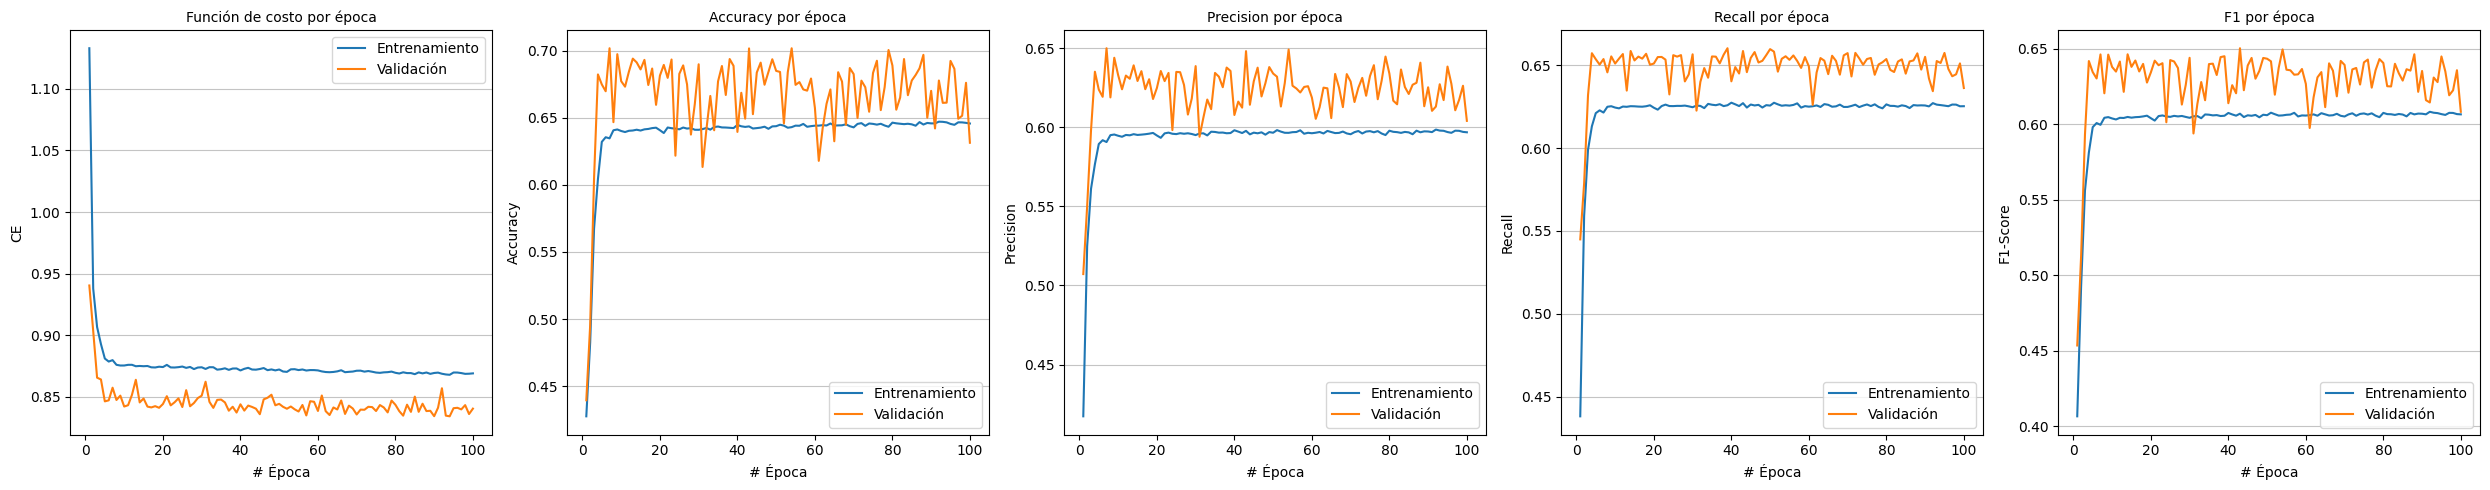

In [ ]:
# Graficar el resultado
x_epochs = list(range(1, epochs + 1))
graphCurves(5, (25, 5), x_epochs, [
    [[train_loss_by_epoch, '# Época', 'CE', 'Entrenamiento', 'Función de costo por época'],
     [valid_loss_by_epoch, '# Época', 'CE', 'Validación', 'Función de costo por época']],
    [[train_acc_by_epoch, '# Época', 'Accuracy', 'Entrenamiento', 'Accuracy por época'],
     [valid_acc_by_epoch, '# Época', 'Accuracy', 'Validación', 'Accuracy por época']],
    [[train_prec_by_epoch, '# Época', 'Precision', 'Entrenamiento', 'Precision por época'],
     [valid_prec_by_epoch, '# Época',  'Precision', 'Validación', 'Precision por época']],
    [[train_rec_by_epoch, '# Época', 'Recall', 'Entrenamiento', 'Recall por época'],
     [valid_rec_by_epoch, '# Época',  'Recall', 'Validación', 'Recall por época']],
    [[train_f1_by_epoch, '# Época', 'F1-Score', 'Entrenamiento', 'F1 por época'],
     [valid_f1_by_epoch, '# Época',  'F1-Score', 'Validación', 'F1 por época']]
])

### Conclusiones

En este caso se ve que al incorporar los embeddings, la misma arquitectura del ejemplo sin embeddings tiene un comportamiento mucho mejor.  

Ejemplo con un set reducido de datos:  
  
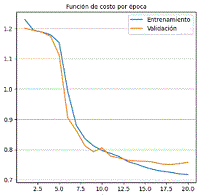
  
Se observa además que, con la arquitectura propuesta, no se requiere de tantas épocas de entrenamiento, porque se llega a un punto donde la función de costo se estabiliza y el modelo ya no aprende ni mejora sus métricas.

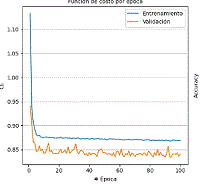


En validación se observa también que la métrica crece rápidamente y luego comienza a oscilar alrededor del valor máximo alcanzado.

Si bien al incorporar los embeddings corría riesgo de sobreajuste, se ve que las métricas en entrenamiento se estabilizan y en validación oscilan pero se mantienen en valores altos (aún más altos que en entrenamiento), por lo que, el modelo está prediciendo de manera aceptable en el conjunto de datos no visto previamente.
  
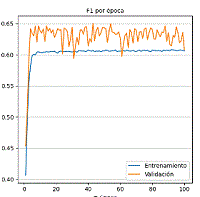
  
  
Para evitar las oscilaciones en la curva de validación podría probar variando el tamaño de los embeddings.
Dado que el tamaño que usé es grande, el modelo podría aprender características de ruido en los datos y eso hacer fluctuar el rendimiento con datos no vistos.
Dado que el tamaño de los embeddings es un hiperparámetro a ajustar, sería una opción adicional a explorar.



## Función para devolver usuarios similares

Para implementar una función que devuelva los n usuarios con un comportamiento similar a un User_ID dado, puedo comparar los embeddings.

1) Obtener el vector de embedding correspondiente al User_ID dado.

2) Calcular similitudes utilizando una medida de similitud (como la distancia coseno o la distancia euclidiana) para comparar el embedding del User_ID dado con los embeddings de los otros usuarios.


* Decido utilizar la distancia coseno, que puede ser más efectiva, ya que se enfoca en la similitud de patrones más que en las magnitudes absolutas (la dirección del embedding puede ser más significativa que su longitud).


3) Ordenar los usuarios en función de la similitud y seleccionar los n más cercanos.

In [ ]:
def getSimilarUsers(model, user_id, user_id_to_idx, n=1):

    global device

    if user_id not in user_id_to_idx:
        # El input no existe
        error = 1
        similar_users = "User_ID no encontrado."

    else:

      # Obtener el embedding del user_id dado
      input_idx = user_id_to_idx[user_id]
      target_embedding = model.user_embeddings(torch.tensor(input_idx).long().to(device))

      # Calcular la similitud coseno
      similarities = []

      # Normalizar el embedding objetivo para calcular la distancia coseno
      target_embedding_normalized = target_embedding / target_embedding.norm()

      for other_user_id in user_id_to_idx.keys():

          if other_user_id != user_id:

              other_idx = user_id_to_idx[other_user_id]

              other_embedding = model.user_embeddings(torch.tensor([other_idx]).long().to(device))

              other_embedding_normalized = other_embedding / other_embedding.norm()

              # Calcular similitud coseno
              similarity = torch.dot(target_embedding_normalized.squeeze(), other_embedding_normalized.squeeze()).item()

              similarities.append((other_user_id, similarity))

      # Ordenar los usuarios según la similitud
      similarities.sort(key=lambda x: x[1], reverse=True)

      # Obtener los n usuarios más similares
      error = 0
      similar_users = [user for user in similarities[:n]]

    return error, similar_users



Tomo un usuario random del set de usuarios válidos para probar la función:

In [ ]:
input_user_id = random.choice(list(user_id_to_idx.keys()))  # Usuario a encontrar
n = 5 # cantidad a obtener

result, similar_users = getSimilarUsers(nnnetWithEmbeddings, input_user_id, user_id_to_idx, n)

if result == 1:
  print(similar_users)
else:
  print(f"Usuarios con comportamiento similar a {input_user_id} y su porcentaje de similitud:\n ")

  for i, similar_user in enumerate(similar_users):
    print(f"{i+1}) {similar_user[0]} ({round(similar_user[1]*100, 2)}%)")



Usuarios con comportamiento similar a 1000913 y su porcentaje de similitud:
 
1) 1000003 (100.0%)
2) 1000004 (100.0%)
3) 1000007 (100.0%)
4) 1000016 (100.0%)
5) 1000021 (100.0%)


## Modelo Regresión con Embeddings

### Preparación de los datos

En este caso elimino la columna 'Label' en lugar de 'Purchase' porque se trata de un modelo de regresión.  

In [ ]:
df3 = dropColumns (df, ['User_ID', 'Product_ID', 'Label'])
df3 = dropColumns (df3, df3.filter(like='Product_Category').columns)

df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 27 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Marital_Status                      550068 non-null  int64
 1   Purchase                            550068 non-null  int64
 2   Gender_encoded                      550068 non-null  int64
 3   Age_encoded                         550068 non-null  int64
 4   Stay_In_Current_City_Years_encoded  550068 non-null  int64
 5   Occupation_1                        550068 non-null  int64
 6   Occupation_2                        550068 non-null  int64
 7   Occupation_3                        550068 non-null  int64
 8   Occupation_4                        550068 non-null  int64
 9   Occupation_5                        550068 non-null  int64
 10  Occupation_6                        550068 non-null  int64
 11  Occupation_7                        550068 non-null 

### División del data set

Se utilizan los mismos embeddings del caso anterior

In [ ]:
# Separarar variable de entrada (x) y target (y)
x3, y3 = separateXY(df3, 'Purchase')

x3.head()

,Marital_Status,Gender_encoded,Age_encoded,Stay_In_Current_City_Years_encoded,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,...,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20,City_B,City_C
0,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,6,4,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


Dado que ya no existen clases, no utilizo *StratifiedShuffleSplit*, si no, divido el dataset simplemente de manera aleatoria.

In [ ]:
# Incluir índices de embeddings para la separación del dataset
x3_u = pd.DataFrame(user_idx, columns=['user_idx'])
x3_p = pd.DataFrame(product_idx, columns=['product_idx'])
x3_w_idx = pd.concat([x3_u, x3_p, x3], axis=1)

x3_w_idx.head()

,user_idx,product_idx,Marital_Status,Gender_encoded,Age_encoded,Stay_In_Current_City_Years_encoded,Occupation_1,Occupation_2,Occupation_3,Occupation_4,...,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20,City_B,City_C
0,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,3,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,4,0,1,6,4,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


Divido en este caso el dataset en tres, para poder probar luego del tuneo de hiperparámetros.

In [ ]:
# Dividir en entrenamiento y prueba
train_x3, val_test_x3, train_y3, val_test_y3 = train_test_split(x3_w_idx, y3, test_size=0.30, random_state=42)

# Dividir el conjunto de test en prubea y validación para tuneo de hiperparámetros
valid_x3, test_x3, valid_y3, test_y3 = train_test_split(val_test_x3, val_test_y3, test_size=0.5, random_state=42)


In [ ]:
train_x3_user, df_train_product_idx = separateXY(train_x3, 'product_idx')
train_x3, df_train_user_idx = separateXY(train_x3_user, 'user_idx')

valid_x3_user, df_valid_product_idx = separateXY(valid_x3, 'product_idx')
valid_x3, df_valid_user_idx = separateXY(valid_x3_user, 'user_idx')

test_x3_user, df_test_product_idx = separateXY(test_x3, 'product_idx')
test_x3, df_test_user_idx = separateXY(test_x3_user, 'user_idx')

In [ ]:
# Convertir los datos a array de numpy y normalizar
train_x3, train_y3 = normToNP(train_x3, train_y3)
valid_x3, valid_y3 = normToNP(valid_x3, valid_y3)
test_x3, test_y3 = normToNP(test_x3, test_y3)

user_idx_train = np.array(df_train_user_idx)
user_idx_valid = np.array(df_valid_user_idx)
user_idx_test = np.array(df_test_user_idx)
product_idx_train = np.array(df_train_product_idx)
product_idx_valid = np.array(df_valid_product_idx)
product_idx_test = np.array(df_test_product_idx)

printSampleNum(x3, [[train_x3, 'Entrenamiento'],
                   [valid_x3, 'Validación'],
                   [test_x3, 'Prueba'],], True)

Cantidad de muestras:

- Entrenamiento: 385047 (70%)
- Validación: 82510 (15%)
- Prueba: 82511 (15%)


In [ ]:
# Embeddings y Dataloaders
train_ds_regression = MyDatasetWithEmbddings(train_x3,
                                             user_idx_train,
                                             product_idx_train,
                                             train_y3)

valid_ds_regression = MyDatasetWithEmbddings(valid_x3,
                                             user_idx_valid,
                                             product_idx_valid,
                                             valid_y3)

test_ds_regression = MyDatasetWithEmbddings(test_x3,
                                             user_idx_test,
                                             product_idx_test,
                                             test_y3)

train_dataloader_reg = DataLoader(train_ds_regression, batch_size = batch_size, shuffle= True)
valid_dataloader_reg = DataLoader(valid_ds_regression, batch_size = batch_size)
test_dataloader_reg = DataLoader(test_ds_regression, batch_size = batch_size)


### Arquitectura de la red

En este caso mantengo la clase *NNetWithEmbeddings* ya que las capas de la red se mantienen igual.

* Capa de entrada lineal con embeddings
* Campas intermedias opcionales lineales con ReLU
* Regularización por Drop out según porcentaje indicado por parámetro
* Capa de salida sin función de activación.



### Función de pérdida

La función de pérdida en cambio sí debo modificarla.  
En este caso utilizo [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) (Error cuadrático medio)

In [ ]:
# MSE
loss_function = torch.nn.MSELoss()

### Métrica de evaluación

Dado que ya estoy utilizando el MSE (Mean Squared Error) en la función de pérdida, decido sumar una métrica adicional y así tener otro indicador para la evaluación del modelo: MAE (Mean Absolute Error)  
  
*MSE*:   
Calcula el promedio de los errores al cuadrado.
Esto significa que los errores más grandes tienen un impacto mucho mayor en el resultado, ya que se elevan al cuadrado.
Es más sensible a los outliers. Los errores grandes contribuyen más al MSE, lo que puede hacer que el modelo se ajuste más a estos puntos atípicos.
  

*MAE*:   
Calcula el promedio de los errores absolutos.
Por lo tanto, todos los errores tienen el mismo peso, independientemente de su magnitud.
Es menos sensible a los outliers, ya que todos los errores se tratan de manera uniforme.  

### Ejecución

Defino la función para procesamiento de la red:

In [ ]:
def processNNetR(model, optimizer, loss_f, epochs, t_dataloader, v_dataloader, embeddings=False, verbose=False):
  """
  model: modelo a entrenar o evaluar
  optimizer: optimizador a utilizar
  loss: función de costo a utilizar
  epochs: Número de épocas a ejecutar
  dataloader: Dataloader del set a ejecutar train y test
  embeddings: Si los datos incluyen embeddings o no
  verbose: True/False - Imprime por pantalla detalles de cada época
  """

  global device

  t_loss_by_epoch = []
  t_mae_by_epoch = []

  v_loss_by_epoch = []
  v_mae_by_epoch = []


  for epoch in range(epochs):

    if verbose:
      print(f'Nro. época: {epoch + 1}/{epochs}')

    # MODO ENTRENAMIENTO
    model.train()

    t_epoch_loss = 0
    t_epoch_mae = 0
    t_epoch_y_hat = []
    t_epoch_y = []

    for i, data in enumerate(t_dataloader):

      if embeddings:
        # Datos del batch con embeddings
        x_batch, user_embed_batch, product_embed_batch, y_batch = data

        # Copia embeddings al device disponible
        user_embed_batch = user_embed_batch.to(device).int()
        product_embed_batch = product_embed_batch.to(device).int()

      else:
        # Datos del batch sin embeddings
        x_batch, y_batch = data

      # Copia al device disponible
      x_batch = x_batch.to(device).float()
      y_batch = y_batch.to(device).float()

      # Resetear gradientes sólo en train
      optimizer.zero_grad()

      if embeddings:
        y_batch_hat = model(x_batch, user_embed_batch, product_embed_batch).squeeze()
      else:
        y_batch_hat = model(x_batch).squeeze()

      # Función de costo
      loss = loss_f(y_batch_hat, y_batch)

      # Backpropagation sólo en train
      loss.backward()
      # Actualizar los parámetros
      optimizer.step()

      # Métrica de validación
      mae = mean_absolute_error(y_batch.cpu().detach().numpy(), y_batch_hat.cpu().detach().numpy())

      # Guardar datos
      t_epoch_loss = t_epoch_loss + loss.item()
      t_epoch_mae += mae


    # Calcular la media de la loss por época para graficar
    t_epoch_loss = t_epoch_loss / len(t_dataloader)
    t_loss_by_epoch.append(t_epoch_loss)
    t_epoch_mae = t_epoch_mae / len(t_dataloader)
    t_mae_by_epoch.append(t_epoch_mae)


    if verbose:
        print(f"Entrenamiento")
        print(f'Loss (MSE): {t_epoch_loss:.4f}, MAE = {t_epoch_mae:.4f}')


    # MODO VALIDACION
    model.eval()

    v_epoch_loss = 0
    v_epoch_mae = 0
    v_epoch_y_hat = []
    v_epoch_y = []

    for i, data in enumerate(v_dataloader):

      if embeddings:
        # Datos del batch con embeddings
        x_batch, user_embed_batch, product_embed_batch, y_batch = data

        # Copia embeddings al device disponible
        user_embed_batch = user_embed_batch.to(device).int()
        product_embed_batch = product_embed_batch.to(device).int()

      else:
        # Datos del batch sin embeddings
        x_batch, y_batch = data

      # Copia al device disponible
      x_batch = x_batch.to(device).float()
      y_batch = y_batch.to(device).float()

      if embeddings:
        y_batch_hat = model(x_batch, user_embed_batch, product_embed_batch).squeeze()
      else:
        y_batch_hat = model(x_batch).squeeze()

      # Función de costo
      loss = loss_f(y_batch_hat, y_batch)

      # Métrica de validación
      mae = mean_absolute_error(y_batch.cpu().detach().numpy(), y_batch_hat.cpu().detach().numpy())

      # Guardar datos
      v_epoch_loss = v_epoch_loss + loss.item()
      v_epoch_mae += mae


    # Calcular la media de la loss por época para graficar
    v_epoch_loss = v_epoch_loss / len(v_dataloader)
    v_loss_by_epoch.append(v_epoch_loss)
    v_epoch_mae = v_epoch_mae / len(v_dataloader)
    v_mae_by_epoch.append(v_epoch_mae)

    if verbose:
        print(f'Validación')
        print(f'Loss (MSE): {v_epoch_loss:.4f}, MAE = {v_epoch_mae:.4f}\n')


  return t_loss_by_epoch, t_mae_by_epoch, v_loss_by_epoch, v_mae_by_epoch

In [ ]:
# Número total de muestras
total_samples = train_y3.shape[0]

# Número de neuronas de salida
output = 1

# Cantidad de características de entrada
n_features = train_x3.shape[1]

# Cantidad de neuronas por capa
n_neurons = [32]

# Cantidad de capas intermedias (entre entrada y salida)
n_layers = len(n_neurons)

# % drop out
drop_out = 0.3

# Cantidad de épocas
epochs = 100

# Learning Rate
learning_rate = 0.001

# Weight Decay
weight_decay = 0.02

In [ ]:
nnnetWithEmbeddingsR = NNetWithEmbeddings(n_features, n_layers, n_neurons, output, drop_out,
               n_user_id, n_product_id, user_embedding_dim, product_embedding_dim)

nnnetWithEmbeddingsR = nnnetWithEmbeddingsR.to(device)

# Optimizador con regularización L2 (parámetro weight_decay)
optimizer = torch.optim.Adam(nnnetWithEmbeddingsR.parameters(), lr=learning_rate, weight_decay=weight_decay)

print(nnnetWithEmbeddingsR)

NNetWithEmbeddings(
  (user_embeddings): Embedding(5891, 76)
  (product_embeddings): Embedding(3631, 60)
  (linear): Linear(in_features=162, out_features=32, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (hidden_layers): ModuleList()
  (output): Linear(in_features=32, out_features=1, bias=True)
)


In [ ]:
(
    train_loss_by_epoch, train_mae_by_epoch, valid_loss_by_epoch, valid_mae_by_epoch

) = processNNetR(nnnetWithEmbeddingsR, optimizer, loss_function, epochs, train_dataloader_reg, valid_dataloader_reg, True, True)

Nro. época: 1/100
Entrenamiento
Loss (MSE): 33373895.8300, MAE = 4089.2162
Validación
Loss: 7967406.5043, MSE = 2063.3731

Nro. época: 2/100
Entrenamiento
Loss (MSE): 8979047.4808, MAE = 2208.8909
Validación
Loss: 6747293.6537, MSE = 1927.1586

Nro. época: 3/100
Entrenamiento
Loss (MSE): 8292194.7585, MAE = 2130.1632
Validación
Loss: 6491980.2886, MSE = 1889.7472

Nro. época: 4/100
Entrenamiento
Loss (MSE): 7900961.6605, MAE = 2080.7842
Validación
Loss: 6461584.2293, MSE = 1892.4006

Nro. época: 5/100
Entrenamiento
Loss (MSE): 7758314.9225, MAE = 2064.5453
Validación
Loss: 6421311.2529, MSE = 1881.3443

Nro. época: 6/100
Entrenamiento
Loss (MSE): 7656250.6124, MAE = 2050.5755
Validación
Loss: 6405924.0219, MSE = 1880.5227

Nro. época: 7/100
Entrenamiento
Loss (MSE): 7598167.4100, MAE = 2043.3605
Validación
Loss: 6440927.3655, MSE = 1888.9930

Nro. época: 8/100
Entrenamiento
Loss (MSE): 7600465.6627, MAE = 2043.0354
Validación
Loss: 6413626.8576, MSE = 1883.7892

Nro. época: 9/100
Entre

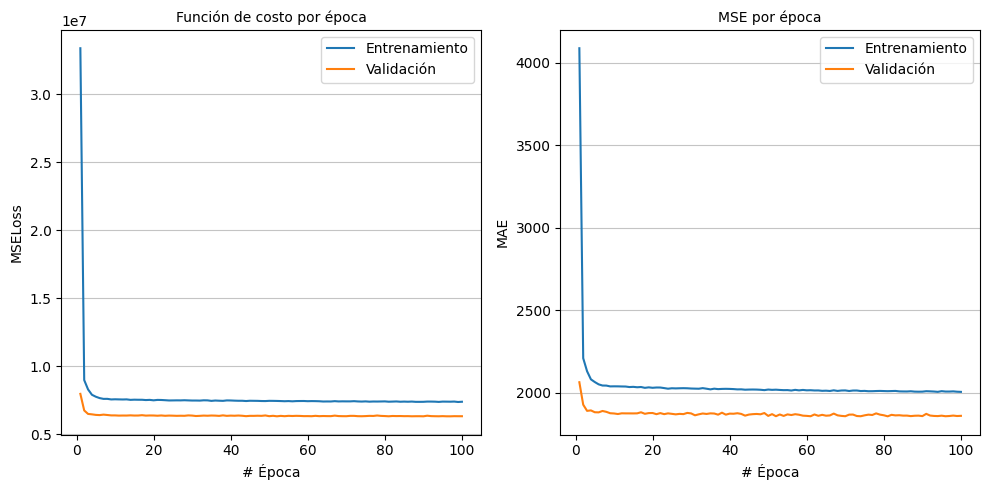

In [ ]:
# Graficar el resultado
x_epochs = list(range(1, epochs + 1))

graphCurves(2, (10, 5), x_epochs, [
    [[train_loss_by_epoch, '# Época', 'MSELoss', 'Entrenamiento', 'Función de costo por época'],
     [valid_loss_by_epoch, '# Época', 'MSELoss', 'Validación', 'Función de costo por época']],
    [[train_mae_by_epoch, '# Época', 'MAE', 'Entrenamiento', 'MAE por época'],
     [valid_mae_by_epoch, '# Época', 'MAE', 'Validación', 'MAE por época']]
])


### Conclusiones

En el caso de regresión, probé varias arquitecturas y en conclusión, el modelo no requiere tantas capas y neuronas como en el problema de clasificación.  
  
Obtuve en general similares resultados con arquitecturas de entre 1 y 3 capas, sin embargo, cuanto más compleja era la arquitectura, se observaba que el modelo tendía a sobreajustar y no generalizaba correctamente.

Ejemplo:

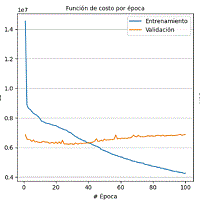
  
Con una arquitectura de sólo una capa de 32 neuronas y suficiente regularización, en las gráficas se observa que, el modelo aprende rápidamente y las métricas se estabilizan y son inferiores en el set de validación, con lo cual, el modelo tiende a generalizar correctamente.  

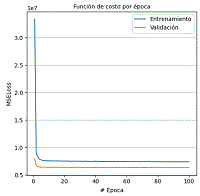

  
Podría explorar otras opciones para ver si los errores disminuyen en magnitud y así obtener predicciones más acertadas.
Por ejemplo, variando la tasa de aprendizaje o las opciones de regularización.

## Ajuste de Hiperparámetros

Realizo el tuning de hiperparámetros con Optuna.

Hiperparámetros a ajustar:
* Tamaño del batch
* Learning Rate
* Weight Decay

In [ ]:
# Cantidad de features
print(train_x3.shape[1])

26


In [ ]:
def objective(trial):

  # MODELO A OPTIMIZAR
  n_features = 26
  drop_out = 0.3
  epochs = 100
  output = 1
  n_neurons = [32]
  n_layers = len(n_neurons)

  # DATOS DEL EJERCICIO PREVIO
  global device
  global n_user_id
  global n_product_id
  global user_embedding_dim
  global product_embedding_dim
  global train_dataloader_reg
  global valid_dataloader_reg

  # HIPERPARÁMETROS A TUNEAR
  batch_size = trial.suggest_int('batch_size', 16, 128)
  learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
  weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)

  print(f"\nOPTUNA Test: learning_rate {learning_rate} | batch_size {batch_size} | weight_decay {weight_decay}\n")


  # MODELO DE REGRESIÓN
  model = NNetWithEmbeddings(n_features, n_layers, n_neurons, output, drop_out,
                              n_user_id, n_product_id, user_embedding_dim, product_embedding_dim)

  model = model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  loss_function = torch.nn.MSELoss()

  # Entrenamiento
  model.train()


  for x_batch, user_embed_batch, product_embed_batch, y_batch in train_dataloader_reg:

    user_embed_batch = user_embed_batch.to(device).long()
    product_embed_batch = product_embed_batch.to(device).long()
    x_batch = x_batch.to(device).float()
    y_batch = y_batch.to(device).float()

    optimizer.zero_grad()
    y_batch_hat = model(x_batch, user_embed_batch, product_embed_batch).squeeze()
    loss = loss_function(y_batch_hat, y_batch)
    loss.backward()
    optimizer.step()

  # Validación
  model.eval()
  total_validation_loss = 0.0

  with torch.no_grad():
      for x_batch, user_embed_batch, product_embed_batch, y_batch in valid_dataloader_reg:
          user_embed_batch = user_embed_batch.to(device).long()
          product_embed_batch = product_embed_batch.to(device).long()
          x_batch = x_batch.to(device).float()
          y_batch = y_batch.to(device).float()

          y_batch_hat = model(x_batch, user_embed_batch, product_embed_batch).squeeze()
          loss = loss_function(y_batch_hat, y_batch)
          total_validation_loss += loss.item()

  # Calcular la pérdida media de validación
  average_validation_loss = total_validation_loss / len(valid_dataloader_reg)

  return average_validation_loss


Ejecuto la búsqueda de hiperparámetros con 50 intentos:

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Resultados
print("Mejores hiperparámetros: ", study.best_params)
print("Mejor pérdida: ", study.best_value)


[I 2024-10-23 18:26:59,375] A new study created in memory with name: no-name-3752b5f1-880f-4a76-90a0-ee554b56c881



OPTUNA Test: learning_rate 0.0023237322393828844 | batch_size 18 | weight_decay 1.6335272260046914e-05



[I 2024-10-23 18:27:15,962] Trial 0 finished with value: 6821074.635077519 and parameters: {'batch_size': 18, 'learning_rate': 0.0023237322393828844, 'weight_decay': 1.6335272260046914e-05}. Best is trial 0 with value: 6821074.635077519.



OPTUNA Test: learning_rate 0.03570236874089996 | batch_size 81 | weight_decay 1.3012025270228454e-05



[I 2024-10-23 18:27:30,631] Trial 1 finished with value: 7247333.725581395 and parameters: {'batch_size': 81, 'learning_rate': 0.03570236874089996, 'weight_decay': 1.3012025270228454e-05}. Best is trial 0 with value: 6821074.635077519.



OPTUNA Test: learning_rate 0.00022580871325863301 | batch_size 60 | weight_decay 0.0096054119411378



[I 2024-10-23 18:27:45,800] Trial 2 finished with value: 64714007.147286825 and parameters: {'batch_size': 60, 'learning_rate': 0.00022580871325863301, 'weight_decay': 0.0096054119411378}. Best is trial 0 with value: 6821074.635077519.



OPTUNA Test: learning_rate 0.004033417119535669 | batch_size 55 | weight_decay 3.055487515644681e-05



[I 2024-10-23 18:28:00,383] Trial 3 finished with value: 6872629.415503876 and parameters: {'batch_size': 55, 'learning_rate': 0.004033417119535669, 'weight_decay': 3.055487515644681e-05}. Best is trial 0 with value: 6821074.635077519.



OPTUNA Test: learning_rate 0.0015697382754328035 | batch_size 99 | weight_decay 8.432636314452699e-05



[I 2024-10-23 18:28:14,932] Trial 4 finished with value: 7069136.452131783 and parameters: {'batch_size': 99, 'learning_rate': 0.0015697382754328035, 'weight_decay': 8.432636314452699e-05}. Best is trial 0 with value: 6821074.635077519.



OPTUNA Test: learning_rate 0.00955431270111864 | batch_size 121 | weight_decay 0.0012438286086841473



[I 2024-10-23 18:28:29,530] Trial 5 finished with value: 7024432.79748062 and parameters: {'batch_size': 121, 'learning_rate': 0.00955431270111864, 'weight_decay': 0.0012438286086841473}. Best is trial 0 with value: 6821074.635077519.



OPTUNA Test: learning_rate 0.06141499792496348 | batch_size 127 | weight_decay 0.009643722327299183



[I 2024-10-23 18:28:44,223] Trial 6 finished with value: 7406934.979457364 and parameters: {'batch_size': 127, 'learning_rate': 0.06141499792496348, 'weight_decay': 0.009643722327299183}. Best is trial 0 with value: 6821074.635077519.



OPTUNA Test: learning_rate 0.0008696682151263038 | batch_size 59 | weight_decay 9.79839235550055e-05



[I 2024-10-23 18:28:59,260] Trial 7 finished with value: 8244889.323255814 and parameters: {'batch_size': 59, 'learning_rate': 0.0008696682151263038, 'weight_decay': 9.79839235550055e-05}. Best is trial 0 with value: 6821074.635077519.



OPTUNA Test: learning_rate 0.035710104763843765 | batch_size 97 | weight_decay 0.0005971053132013697



[I 2024-10-23 18:29:14,182] Trial 8 finished with value: 7030901.936821706 and parameters: {'batch_size': 97, 'learning_rate': 0.035710104763843765, 'weight_decay': 0.0005971053132013697}. Best is trial 0 with value: 6821074.635077519.



OPTUNA Test: learning_rate 0.005976151667677003 | batch_size 31 | weight_decay 5.38888570726335e-05



[I 2024-10-23 18:29:28,961] Trial 9 finished with value: 7051411.103488372 and parameters: {'batch_size': 31, 'learning_rate': 0.005976151667677003, 'weight_decay': 5.38888570726335e-05}. Best is trial 0 with value: 6821074.635077519.



OPTUNA Test: learning_rate 2.3458960147772898e-05 | batch_size 17 | weight_decay 1.3261654214130539e-05



[I 2024-10-23 18:29:43,567] Trial 10 finished with value: 111201814.8620155 and parameters: {'batch_size': 17, 'learning_rate': 2.3458960147772898e-05, 'weight_decay': 1.3261654214130539e-05}. Best is trial 0 with value: 6821074.635077519.



OPTUNA Test: learning_rate 0.0002979537659216092 | batch_size 41 | weight_decay 3.379595143325333e-05



[I 2024-10-23 18:29:58,280] Trial 11 finished with value: 40713881.21705426 and parameters: {'batch_size': 41, 'learning_rate': 0.0002979537659216092, 'weight_decay': 3.379595143325333e-05}. Best is trial 0 with value: 6821074.635077519.



OPTUNA Test: learning_rate 0.0037242945729529043 | batch_size 44 | weight_decay 0.00020424707753085463



[I 2024-10-23 18:30:13,143] Trial 12 finished with value: 6876817.364341085 and parameters: {'batch_size': 44, 'learning_rate': 0.0037242945729529043, 'weight_decay': 0.00020424707753085463}. Best is trial 0 with value: 6821074.635077519.



OPTUNA Test: learning_rate 0.00010316935749772576 | batch_size 17 | weight_decay 2.481999227276298e-05



[I 2024-10-23 18:30:28,281] Trial 13 finished with value: 106685846.3007752 and parameters: {'batch_size': 17, 'learning_rate': 0.00010316935749772576, 'weight_decay': 2.481999227276298e-05}. Best is trial 0 with value: 6821074.635077519.



OPTUNA Test: learning_rate 0.0011249578330266435 | batch_size 70 | weight_decay 0.000179155185447553



[I 2024-10-23 18:30:42,781] Trial 14 finished with value: 7501836.011627907 and parameters: {'batch_size': 70, 'learning_rate': 0.0011249578330266435, 'weight_decay': 0.000179155185447553}. Best is trial 0 with value: 6821074.635077519.



OPTUNA Test: learning_rate 0.011190697643962444 | batch_size 32 | weight_decay 1.0387818911159941e-05



[I 2024-10-23 18:30:57,404] Trial 15 finished with value: 7020398.772286822 and parameters: {'batch_size': 32, 'learning_rate': 0.011190697643962444, 'weight_decay': 1.0387818911159941e-05}. Best is trial 0 with value: 6821074.635077519.



OPTUNA Test: learning_rate 0.0033237815774088296 | batch_size 51 | weight_decay 3.099329224355929e-05



[I 2024-10-23 18:31:11,961] Trial 16 finished with value: 6832398.028875969 and parameters: {'batch_size': 51, 'learning_rate': 0.0033237815774088296, 'weight_decay': 3.099329224355929e-05}. Best is trial 0 with value: 6821074.635077519.



OPTUNA Test: learning_rate 0.00045828566789876744 | batch_size 30 | weight_decay 0.0020138836218449936



[I 2024-10-23 18:31:26,644] Trial 17 finished with value: 14689241.41007752 and parameters: {'batch_size': 30, 'learning_rate': 0.00045828566789876744, 'weight_decay': 0.0020138836218449936}. Best is trial 0 with value: 6821074.635077519.



OPTUNA Test: learning_rate 2.672634533817477e-05 | batch_size 79 | weight_decay 0.00037365117082850674



[I 2024-10-23 18:31:42,049] Trial 18 finished with value: 111181304.2511628 and parameters: {'batch_size': 79, 'learning_rate': 2.672634533817477e-05, 'weight_decay': 0.00037365117082850674}. Best is trial 0 with value: 6821074.635077519.



OPTUNA Test: learning_rate 8.029014816145873e-05 | batch_size 43 | weight_decay 6.277033259224531e-05



[I 2024-10-23 18:31:56,789] Trial 19 finished with value: 109338017.6992248 and parameters: {'batch_size': 43, 'learning_rate': 8.029014816145873e-05, 'weight_decay': 6.277033259224531e-05}. Best is trial 0 with value: 6821074.635077519.



OPTUNA Test: learning_rate 0.002170058616076891 | batch_size 51 | weight_decay 3.079876543074789e-05



[I 2024-10-23 18:32:12,125] Trial 20 finished with value: 6822813.453100775 and parameters: {'batch_size': 51, 'learning_rate': 0.002170058616076891, 'weight_decay': 3.079876543074789e-05}. Best is trial 0 with value: 6821074.635077519.



OPTUNA Test: learning_rate 0.001848460125550311 | batch_size 50 | weight_decay 2.1576639780279344e-05



[I 2024-10-23 18:32:26,875] Trial 21 finished with value: 6895846.606782946 and parameters: {'batch_size': 50, 'learning_rate': 0.001848460125550311, 'weight_decay': 2.1576639780279344e-05}. Best is trial 0 with value: 6821074.635077519.



OPTUNA Test: learning_rate 0.02030152074919743 | batch_size 65 | weight_decay 4.027874596519342e-05



[I 2024-10-23 18:32:41,366] Trial 22 finished with value: 7114444.595930233 and parameters: {'batch_size': 65, 'learning_rate': 0.02030152074919743, 'weight_decay': 4.027874596519342e-05}. Best is trial 0 with value: 6821074.635077519.



OPTUNA Test: learning_rate 0.002785616788914527 | batch_size 30 | weight_decay 0.000129103608708386



[I 2024-10-23 18:32:56,669] Trial 23 finished with value: 6806894.470348837 and parameters: {'batch_size': 30, 'learning_rate': 0.002785616788914527, 'weight_decay': 0.000129103608708386}. Best is trial 23 with value: 6806894.470348837.



OPTUNA Test: learning_rate 0.0006022431161997072 | batch_size 25 | weight_decay 0.00011176723468172698



[I 2024-10-23 18:33:11,363] Trial 24 finished with value: 10729520.269379845 and parameters: {'batch_size': 25, 'learning_rate': 0.0006022431161997072, 'weight_decay': 0.00011176723468172698}. Best is trial 23 with value: 6806894.470348837.



OPTUNA Test: learning_rate 0.011207347218324067 | batch_size 36 | weight_decay 0.0001621491561790992



[I 2024-10-23 18:33:26,020] Trial 25 finished with value: 6970199.211627907 and parameters: {'batch_size': 36, 'learning_rate': 0.011207347218324067, 'weight_decay': 0.0001621491561790992}. Best is trial 23 with value: 6806894.470348837.



OPTUNA Test: learning_rate 0.0022747528596265437 | batch_size 23 | weight_decay 2.043577532203962e-05



[I 2024-10-23 18:33:40,650] Trial 26 finished with value: 6817101.303682171 and parameters: {'batch_size': 23, 'learning_rate': 0.0022747528596265437, 'weight_decay': 2.043577532203962e-05}. Best is trial 23 with value: 6806894.470348837.



OPTUNA Test: learning_rate 0.006465708335847708 | batch_size 23 | weight_decay 1.7610595226540622e-05



[I 2024-10-23 18:33:55,296] Trial 27 finished with value: 6953834.006589147 and parameters: {'batch_size': 23, 'learning_rate': 0.006465708335847708, 'weight_decay': 1.7610595226540622e-05}. Best is trial 23 with value: 6806894.470348837.



OPTUNA Test: learning_rate 0.09938162506279334 | batch_size 16 | weight_decay 0.0004370956695680111



[I 2024-10-23 18:34:10,022] Trial 28 finished with value: 7746524.0170542635 and parameters: {'batch_size': 16, 'learning_rate': 0.09938162506279334, 'weight_decay': 0.0004370956695680111}. Best is trial 23 with value: 6806894.470348837.



OPTUNA Test: learning_rate 0.024941962055582773 | batch_size 25 | weight_decay 1.4038560657924199e-05



[I 2024-10-23 18:34:25,294] Trial 29 finished with value: 7062167.747093023 and parameters: {'batch_size': 25, 'learning_rate': 0.024941962055582773, 'weight_decay': 1.4038560657924199e-05}. Best is trial 23 with value: 6806894.470348837.



OPTUNA Test: learning_rate 0.0008244442354780341 | batch_size 38 | weight_decay 0.0009101169410898649



[I 2024-10-23 18:34:39,996] Trial 30 finished with value: 8762025.185852714 and parameters: {'batch_size': 38, 'learning_rate': 0.0008244442354780341, 'weight_decay': 0.0009101169410898649}. Best is trial 23 with value: 6806894.470348837.



OPTUNA Test: learning_rate 0.0019492761641056282 | batch_size 27 | weight_decay 5.3184787950580954e-05



[I 2024-10-23 18:34:54,579] Trial 31 finished with value: 6863701.18120155 and parameters: {'batch_size': 27, 'learning_rate': 0.0019492761641056282, 'weight_decay': 5.3184787950580954e-05}. Best is trial 23 with value: 6806894.470348837.



OPTUNA Test: learning_rate 0.002399889477653018 | batch_size 47 | weight_decay 2.1587268137417348e-05



[I 2024-10-23 18:35:09,161] Trial 32 finished with value: 6798330.334689923 and parameters: {'batch_size': 47, 'learning_rate': 0.002399889477653018, 'weight_decay': 2.1587268137417348e-05}. Best is trial 32 with value: 6798330.334689923.



OPTUNA Test: learning_rate 0.003133936401523252 | batch_size 35 | weight_decay 1.76845667397042e-05



[I 2024-10-23 18:35:23,732] Trial 33 finished with value: 6858530.761434109 and parameters: {'batch_size': 35, 'learning_rate': 0.003133936401523252, 'weight_decay': 1.76845667397042e-05}. Best is trial 32 with value: 6798330.334689923.



OPTUNA Test: learning_rate 0.0003131926729378017 | batch_size 21 | weight_decay 1.0109543586187508e-05



[I 2024-10-23 18:35:38,907] Trial 34 finished with value: 28986394.60232558 and parameters: {'batch_size': 21, 'learning_rate': 0.0003131926729378017, 'weight_decay': 1.0109543586187508e-05}. Best is trial 32 with value: 6798330.334689923.



OPTUNA Test: learning_rate 0.0014208326793094179 | batch_size 44 | weight_decay 0.003463050799036255



[I 2024-10-23 18:35:53,660] Trial 35 finished with value: 7169504.988953488 and parameters: {'batch_size': 44, 'learning_rate': 0.0014208326793094179, 'weight_decay': 0.003463050799036255}. Best is trial 32 with value: 6798330.334689923.



OPTUNA Test: learning_rate 0.005952556728070708 | batch_size 29 | weight_decay 7.667144137452616e-05



[I 2024-10-23 18:36:08,258] Trial 36 finished with value: 6955548.694573644 and parameters: {'batch_size': 29, 'learning_rate': 0.005952556728070708, 'weight_decay': 7.667144137452616e-05}. Best is trial 32 with value: 6798330.334689923.



OPTUNA Test: learning_rate 0.00014271522284965108 | batch_size 93 | weight_decay 0.0001271054924981026



[I 2024-10-23 18:36:22,887] Trial 37 finished with value: 98369939.11007752 and parameters: {'batch_size': 93, 'learning_rate': 0.00014271522284965108, 'weight_decay': 0.0001271054924981026}. Best is trial 32 with value: 6798330.334689923.



OPTUNA Test: learning_rate 0.015776451429230433 | batch_size 59 | weight_decay 4.6550607754829434e-05



[I 2024-10-23 18:36:37,420] Trial 38 finished with value: 7010080.108527131 and parameters: {'batch_size': 59, 'learning_rate': 0.015776451429230433, 'weight_decay': 4.6550607754829434e-05}. Best is trial 32 with value: 6798330.334689923.



OPTUNA Test: learning_rate 0.0005836321424261376 | batch_size 113 | weight_decay 2.292109015043636e-05



[I 2024-10-23 18:36:52,147] Trial 39 finished with value: 10870841.72751938 and parameters: {'batch_size': 113, 'learning_rate': 0.0005836321424261376, 'weight_decay': 2.292109015043636e-05}. Best is trial 32 with value: 6798330.334689923.



OPTUNA Test: learning_rate 0.00608198350520127 | batch_size 20 | weight_decay 0.0002620712795851742



[I 2024-10-23 18:37:07,298] Trial 40 finished with value: 6999263.700387597 and parameters: {'batch_size': 20, 'learning_rate': 0.00608198350520127, 'weight_decay': 0.0002620712795851742}. Best is trial 32 with value: 6798330.334689923.



OPTUNA Test: learning_rate 0.002124864566689464 | batch_size 51 | weight_decay 3.127653984584654e-05



[I 2024-10-23 18:37:22,788] Trial 41 finished with value: 6833783.563953488 and parameters: {'batch_size': 51, 'learning_rate': 0.002124864566689464, 'weight_decay': 3.127653984584654e-05}. Best is trial 32 with value: 6798330.334689923.



OPTUNA Test: learning_rate 0.0028034938085102126 | batch_size 49 | weight_decay 1.5851852862999446e-05



[I 2024-10-23 18:37:37,442] Trial 42 finished with value: 6797184.072674419 and parameters: {'batch_size': 49, 'learning_rate': 0.0028034938085102126, 'weight_decay': 1.5851852862999446e-05}. Best is trial 42 with value: 6797184.072674419.



OPTUNA Test: learning_rate 0.0011450996094942213 | batch_size 39 | weight_decay 1.5236108001108095e-05



[I 2024-10-23 18:37:52,672] Trial 43 finished with value: 7457629.28875969 and parameters: {'batch_size': 39, 'learning_rate': 0.0011450996094942213, 'weight_decay': 1.5236108001108095e-05}. Best is trial 42 with value: 6797184.072674419.



OPTUNA Test: learning_rate 0.004461001510792938 | batch_size 64 | weight_decay 2.001574283836863e-05



[I 2024-10-23 18:38:07,917] Trial 44 finished with value: 6925668.212596899 and parameters: {'batch_size': 64, 'learning_rate': 0.004461001510792938, 'weight_decay': 2.001574283836863e-05}. Best is trial 42 with value: 6797184.072674419.



OPTUNA Test: learning_rate 0.0026885999731326832 | batch_size 47 | weight_decay 7.205685765374528e-05



[I 2024-10-23 18:38:23,848] Trial 45 finished with value: 6826804.968410852 and parameters: {'batch_size': 47, 'learning_rate': 0.0026885999731326832, 'weight_decay': 7.205685765374528e-05}. Best is trial 42 with value: 6797184.072674419.



OPTUNA Test: learning_rate 0.007977987224620621 | batch_size 32 | weight_decay 1.2284284482531443e-05



[I 2024-10-23 18:38:38,834] Trial 46 finished with value: 7033196.870348837 and parameters: {'batch_size': 32, 'learning_rate': 0.007977987224620621, 'weight_decay': 1.2284284482531443e-05}. Best is trial 42 with value: 6797184.072674419.



OPTUNA Test: learning_rate 0.0008699036060751474 | batch_size 55 | weight_decay 0.005342160828921339



[I 2024-10-23 18:38:53,927] Trial 47 finished with value: 8184485.966666667 and parameters: {'batch_size': 55, 'learning_rate': 0.0008699036060751474, 'weight_decay': 0.005342160828921339}. Best is trial 42 with value: 6797184.072674419.



OPTUNA Test: learning_rate 0.003763906090820766 | batch_size 79 | weight_decay 4.17657390806265e-05



[I 2024-10-23 18:39:08,957] Trial 48 finished with value: 6855618.253488372 and parameters: {'batch_size': 79, 'learning_rate': 0.003763906090820766, 'weight_decay': 4.17657390806265e-05}. Best is trial 42 with value: 6797184.072674419.



OPTUNA Test: learning_rate 0.0013096377441606 | batch_size 34 | weight_decay 2.3869517857488535e-05



[I 2024-10-23 18:39:24,071] Trial 49 finished with value: 7207465.495155038 and parameters: {'batch_size': 34, 'learning_rate': 0.0013096377441606, 'weight_decay': 2.3869517857488535e-05}. Best is trial 42 with value: 6797184.072674419.


Mejores hiperparámetros:  {'batch_size': 49, 'learning_rate': 0.0028034938085102126, 'weight_decay': 1.5851852862999446e-05}
Mejor pérdida:  6797184.072674419


Pruebo en el set de test el desempeño con los hiperparámetos encontrados.

In [ ]:
batch_size = study.best_params['batch_size']
learning_rate = study.best_params['learning_rate']
weight_decay = study.best_params['weight_decay']

In [ ]:
nnnetWithEmbeddingsR.eval()

predictions = []
y_true = []

with torch.no_grad():
    for data in test_dataloader_reg:

        x_batch, user_embed_batch, product_embed_batch, y_batch = data

        # Copia embeddings al device disponible
        user_embed_batch = user_embed_batch.to(device).int()
        product_embed_batch = product_embed_batch.to(device).int()

        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        y_batch_hat = nnnetWithEmbeddingsR(x_batch, user_embed_batch, product_embed_batch).squeeze()

        predictions.append(y_batch_hat.cpu().detach().numpy())
        y_true.append(y_batch.cpu().detach().numpy())

predictions = np.concatenate(predictions)
y_true = np.concatenate(y_true)

mae = mean_absolute_error(y_true, predictions)
mse = mean_squared_error(y_true, predictions)

print(f'MAE: {mae}, MSE: {mse}')



MAE: 1861.7421875, MSE: 6374277.0


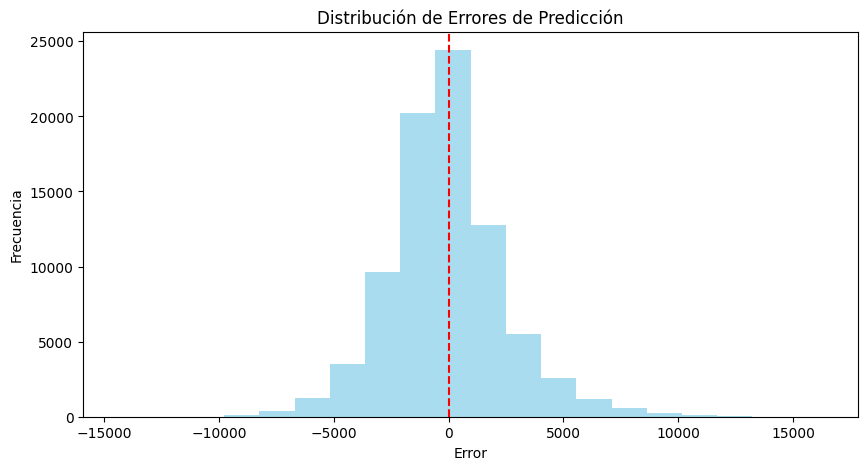

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(errors, bins=20, alpha=0.7, color='skyblue')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores de Predicción')
plt.show()


## Conclusiones

Luego del tuneo de hiperparámetros probé el desempeño del modelo con el set de testeo (datos nunca vistos previamente que mantienen la distribución del conjunto de datos completo).  

Graficando el histograma de los errores para entender el comportamiento, se ve que, la mayoría de los errores cometidos están cercanos al cero, lo que es una buena señal de que el modelo está prediciendo valores correctos.  

La distribución en forma de campana centrada alrededor de cero, me da idea de que el modelo está cometiendo errores de manera equilibrada entre predicciones por encima y por debajo de los valores reales. Esto es un buen signo de que el modelo aprendió correctamente.  

Sin embargo, el rango de errores es bastante amplio, con lo cual, hay oportunidad de mejora para evitar que se cometan errores más grandes aunque no sean los que prevalecen.
  
Se observan también picos más altos en los valores cercanos a cero del lado negativo, por lo que, el modelo podría tener un sesgo positivo y tender a subestimar.  
  
Todo esto se puede tener en cuenta para hacer ajustes en el modelo y obtener mejores predicciones.
